# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

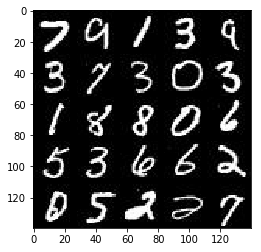

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

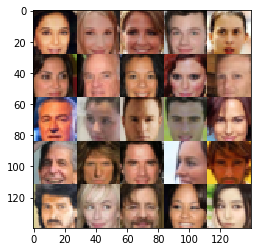

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        
        layer_1 = tf.layers.dense(images, 100, activation=None)
        layer_1 = tf.reshape(layer_1, (-1, 28*28*100))
        logits = tf.layers.dense(layer_1, 1, activation=None)
        out = tf.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [11]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function

    with tf.variable_scope('generator', reuse=not is_train):
        fc1 = tf.layers.dense(z, 7*7*256)
        
        # Reshape
        x1 = tf.reshape(fc1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.nn.relu(x1)

        # Second layer 
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='SAME')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.nn.relu(x2)
        
        # Ouput layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='SAME')
        out = tf.tanh(logits)
        
        return out
        


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [12]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    model_gen = generator(input_z, out_channel_dim)
    
    dis_model_real, dis_logits_real = discriminator(input_real)
    
    dis_model_fake, dis_logits_fake = discriminator(model_gen, reuse=True)
    
    dis_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_real, labels=tf.ones_like(dis_logits_real) * 0.9))
    
    dis_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.zeros_like(dis_logits_fake)))
    
    dis_loss = dis_loss_real + dis_loss_fake
    
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.ones_like(dis_logits_fake)))
    
    return dis_loss, gen_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [13]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    train_vars = tf.trainable_variables()
    
    dis_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    
    with tf.control_dependencies(gen_updates):
        dis_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=dis_vars)
        gen_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
    
        return dis_train_ops, gen_train_ops


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    out_channel_dim = 3 if data_image_mode == "RGB" else 1
    
    input_real, input_z, l_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    iteration = 0
    batches = get_batches(batch_size)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # TODO: Train Model
                
                iteration += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
                
                if iteration % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}, iteration {}:".format(epoch_i + 1, epochs, iteration),
                          "Discriminator Loss: {:.4f},".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if iteration % 10 == 0:
                    show_generator_output(sess, 5, input_z, out_channel_dim, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2, iteration 10: Discriminator Loss: 1.5024, Generator Loss: 0.5540


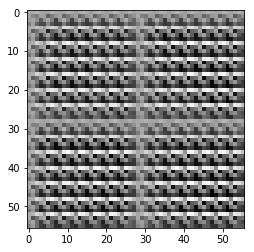

Epoch 1/2, iteration 20: Discriminator Loss: 0.9177, Generator Loss: 1.9284


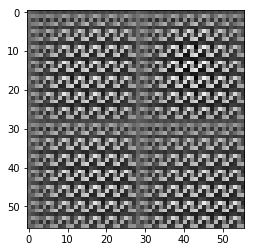

Epoch 1/2, iteration 30: Discriminator Loss: 9.3953, Generator Loss: 0.0002


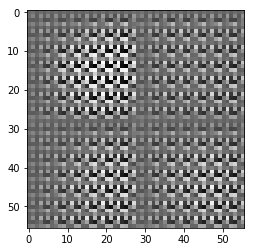

Epoch 1/2, iteration 40: Discriminator Loss: 3.7948, Generator Loss: 0.0694


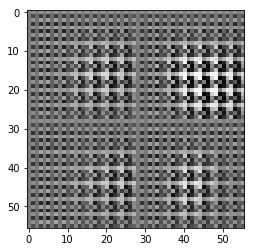

Epoch 1/2, iteration 50: Discriminator Loss: 3.7232, Generator Loss: 0.0438


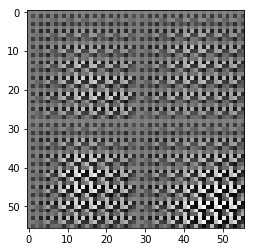

Epoch 1/2, iteration 60: Discriminator Loss: 4.9335, Generator Loss: 0.8269


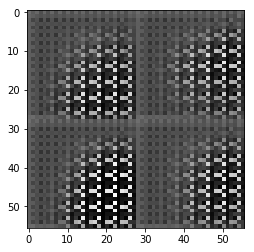

Epoch 1/2, iteration 70: Discriminator Loss: 5.0087, Generator Loss: 0.5222


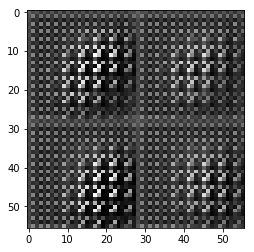

Epoch 1/2, iteration 80: Discriminator Loss: 3.4674, Generator Loss: 0.6041


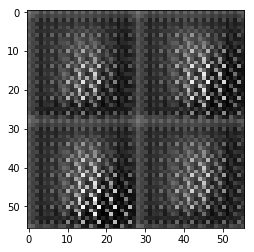

Epoch 1/2, iteration 90: Discriminator Loss: 4.4491, Generator Loss: 0.3072


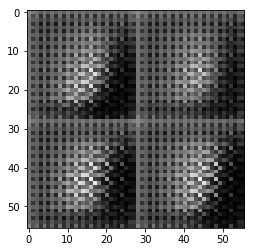

Epoch 1/2, iteration 100: Discriminator Loss: 3.9825, Generator Loss: 0.1886


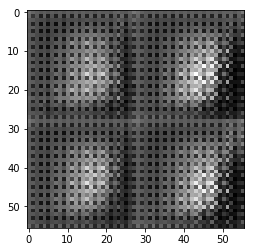

Epoch 1/2, iteration 110: Discriminator Loss: 3.3496, Generator Loss: 0.2831


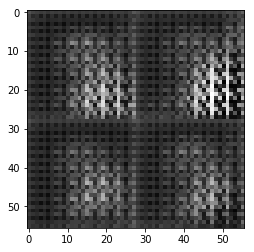

Epoch 1/2, iteration 120: Discriminator Loss: 3.4453, Generator Loss: 0.1927


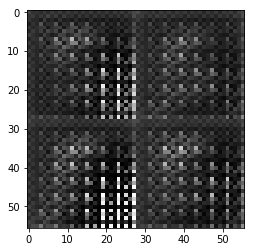

Epoch 1/2, iteration 130: Discriminator Loss: 1.2463, Generator Loss: 0.8340


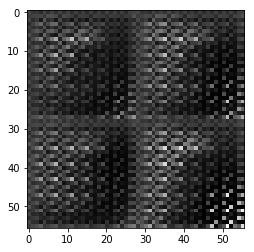

Epoch 1/2, iteration 140: Discriminator Loss: 1.9619, Generator Loss: 0.4739


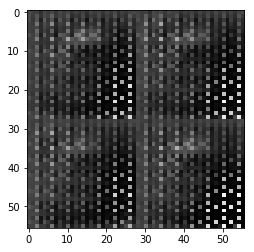

Epoch 1/2, iteration 150: Discriminator Loss: 2.5727, Generator Loss: 0.4646


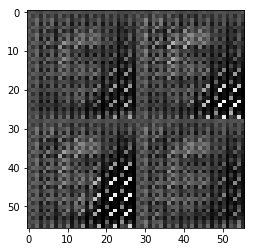

Epoch 1/2, iteration 160: Discriminator Loss: 2.3063, Generator Loss: 0.4678


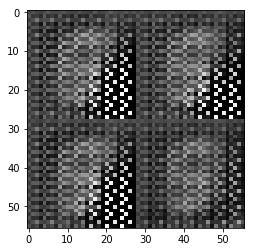

Epoch 1/2, iteration 170: Discriminator Loss: 2.9362, Generator Loss: 0.3710


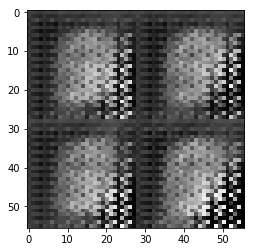

Epoch 1/2, iteration 180: Discriminator Loss: 1.7297, Generator Loss: 0.6768


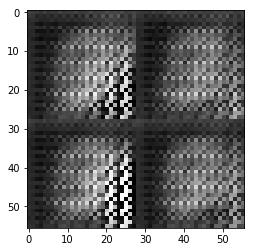

Epoch 1/2, iteration 190: Discriminator Loss: 1.8031, Generator Loss: 0.6439


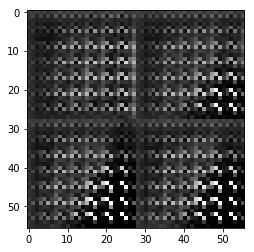

Epoch 1/2, iteration 200: Discriminator Loss: 1.8182, Generator Loss: 0.5359


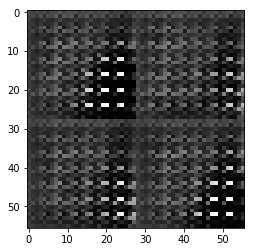

Epoch 1/2, iteration 210: Discriminator Loss: 1.5107, Generator Loss: 0.6851


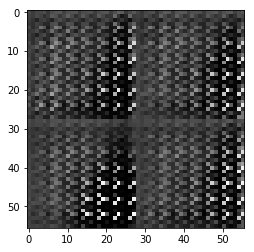

Epoch 1/2, iteration 220: Discriminator Loss: 1.3468, Generator Loss: 0.8040


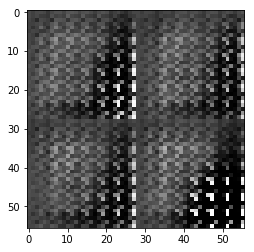

Epoch 1/2, iteration 230: Discriminator Loss: 1.7634, Generator Loss: 0.5589


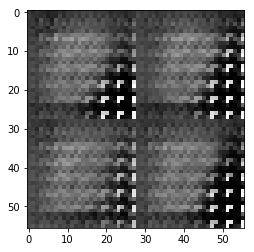

Epoch 1/2, iteration 240: Discriminator Loss: 1.9728, Generator Loss: 0.5384


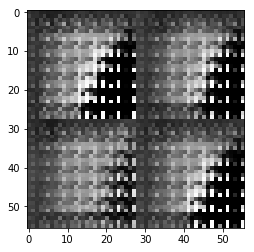

Epoch 1/2, iteration 250: Discriminator Loss: 2.0292, Generator Loss: 0.5473


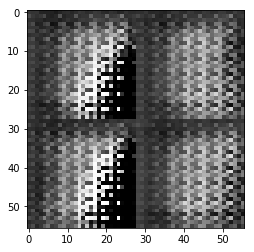

Epoch 1/2, iteration 260: Discriminator Loss: 1.4948, Generator Loss: 0.7572


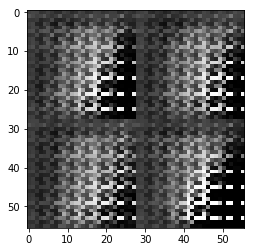

Epoch 1/2, iteration 270: Discriminator Loss: 1.2599, Generator Loss: 0.8776


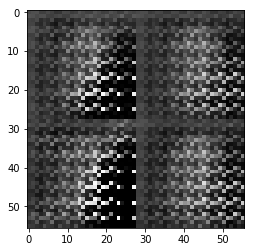

Epoch 1/2, iteration 280: Discriminator Loss: 1.3634, Generator Loss: 0.8227


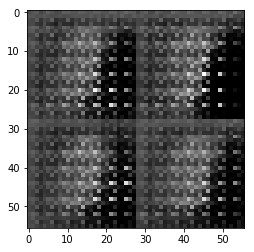

Epoch 1/2, iteration 290: Discriminator Loss: 1.2416, Generator Loss: 0.8980


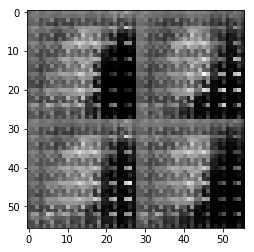

Epoch 1/2, iteration 300: Discriminator Loss: 1.4679, Generator Loss: 0.7682


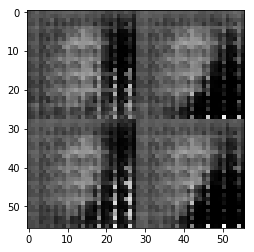

Epoch 1/2, iteration 310: Discriminator Loss: 1.7670, Generator Loss: 0.6744


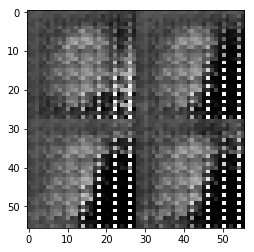

Epoch 1/2, iteration 320: Discriminator Loss: 1.7520, Generator Loss: 0.6661


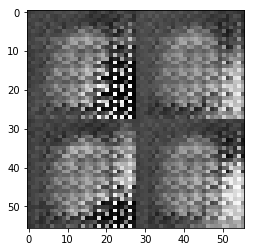

Epoch 1/2, iteration 330: Discriminator Loss: 1.3611, Generator Loss: 0.8187


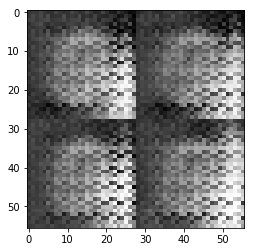

Epoch 1/2, iteration 340: Discriminator Loss: 1.2407, Generator Loss: 0.8688


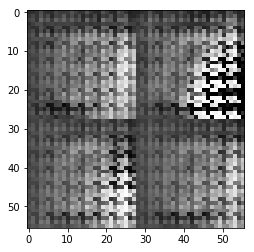

Epoch 1/2, iteration 350: Discriminator Loss: 1.3868, Generator Loss: 0.7752


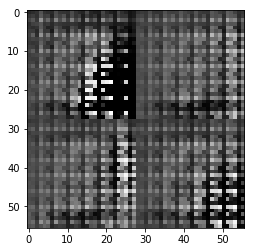

Epoch 1/2, iteration 360: Discriminator Loss: 1.5040, Generator Loss: 0.7487


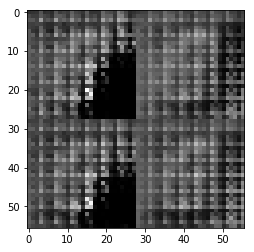

Epoch 1/2, iteration 370: Discriminator Loss: 1.4578, Generator Loss: 0.7711


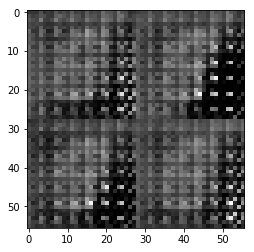

Epoch 1/2, iteration 380: Discriminator Loss: 1.4247, Generator Loss: 0.7867


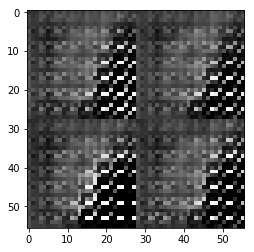

Epoch 1/2, iteration 390: Discriminator Loss: 1.3505, Generator Loss: 0.8249


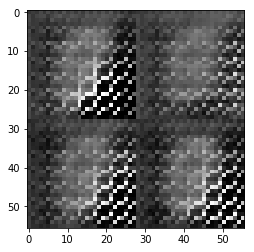

Epoch 1/2, iteration 400: Discriminator Loss: 1.4734, Generator Loss: 0.7366


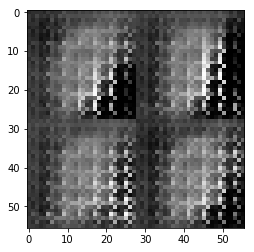

Epoch 1/2, iteration 410: Discriminator Loss: 1.3607, Generator Loss: 0.7948


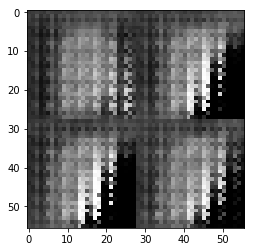

Epoch 1/2, iteration 420: Discriminator Loss: 1.2947, Generator Loss: 0.8255


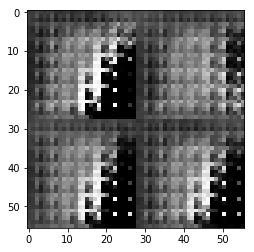

Epoch 1/2, iteration 430: Discriminator Loss: 1.4526, Generator Loss: 0.7643


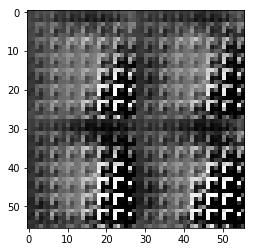

Epoch 1/2, iteration 440: Discriminator Loss: 1.3267, Generator Loss: 0.8676


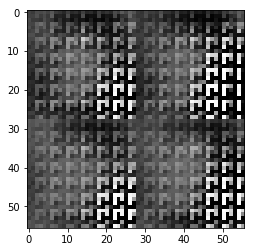

Epoch 1/2, iteration 450: Discriminator Loss: 1.3753, Generator Loss: 0.8456


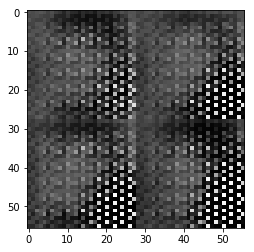

Epoch 1/2, iteration 460: Discriminator Loss: 1.4658, Generator Loss: 0.7535


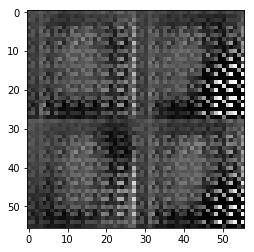

Epoch 2/2, iteration 470: Discriminator Loss: 1.5175, Generator Loss: 0.7089


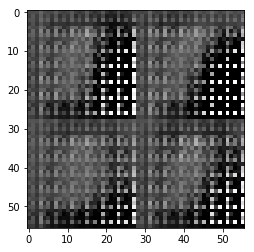

Epoch 2/2, iteration 480: Discriminator Loss: 1.0344, Generator Loss: 1.0624


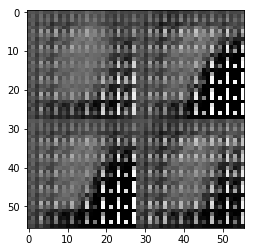

Epoch 2/2, iteration 490: Discriminator Loss: 1.1335, Generator Loss: 0.9235


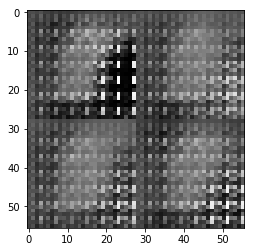

Epoch 2/2, iteration 500: Discriminator Loss: 1.9812, Generator Loss: 0.5466


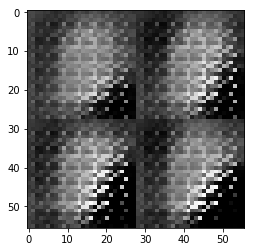

Epoch 2/2, iteration 510: Discriminator Loss: 1.3976, Generator Loss: 0.8372


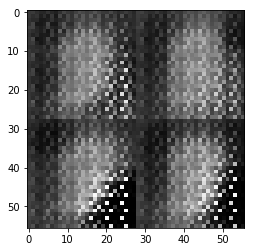

Epoch 2/2, iteration 520: Discriminator Loss: 1.3732, Generator Loss: 0.8339


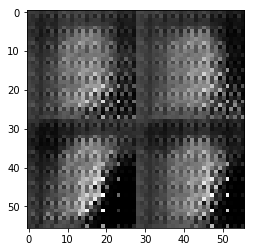

Epoch 2/2, iteration 530: Discriminator Loss: 1.5588, Generator Loss: 0.7099


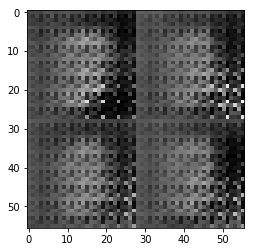

Epoch 2/2, iteration 540: Discriminator Loss: 1.4563, Generator Loss: 0.7419


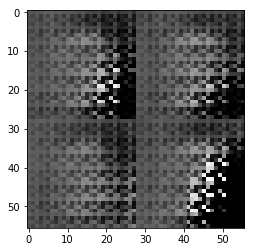

Epoch 2/2, iteration 550: Discriminator Loss: 1.2436, Generator Loss: 0.8788


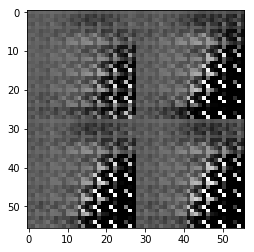

Epoch 2/2, iteration 560: Discriminator Loss: 1.2160, Generator Loss: 0.9296


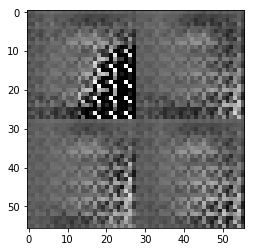

Epoch 2/2, iteration 570: Discriminator Loss: 1.5544, Generator Loss: 0.7111


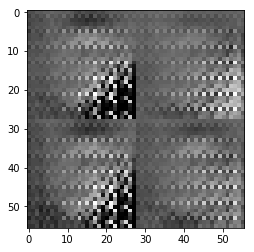

Epoch 2/2, iteration 580: Discriminator Loss: 1.6829, Generator Loss: 0.6564


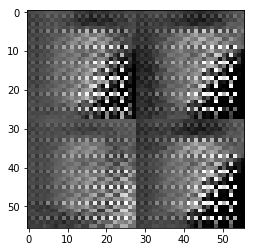

Epoch 2/2, iteration 590: Discriminator Loss: 1.2374, Generator Loss: 0.9067


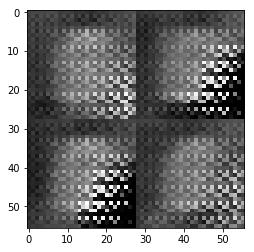

Epoch 2/2, iteration 600: Discriminator Loss: 1.4058, Generator Loss: 0.7647


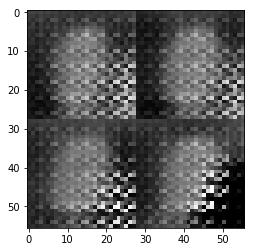

Epoch 2/2, iteration 610: Discriminator Loss: 1.6462, Generator Loss: 0.6598


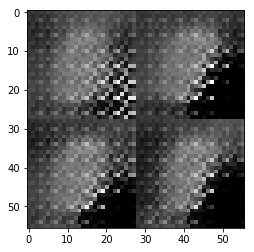

Epoch 2/2, iteration 620: Discriminator Loss: 1.2510, Generator Loss: 0.8765


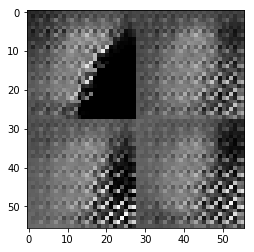

Epoch 2/2, iteration 630: Discriminator Loss: 1.0973, Generator Loss: 0.9818


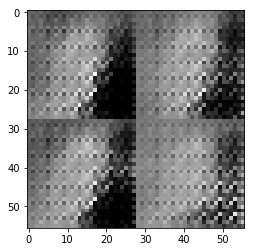

Epoch 2/2, iteration 640: Discriminator Loss: 1.3969, Generator Loss: 0.7646


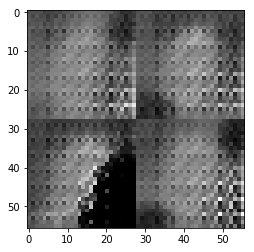

Epoch 2/2, iteration 650: Discriminator Loss: 1.4791, Generator Loss: 0.7828


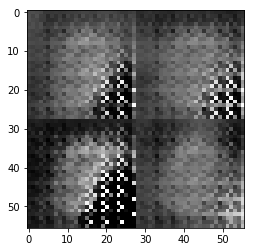

Epoch 2/2, iteration 660: Discriminator Loss: 1.4695, Generator Loss: 0.7509


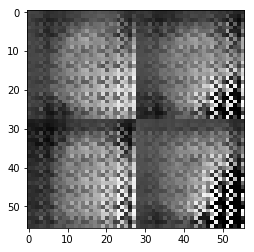

Epoch 2/2, iteration 670: Discriminator Loss: 1.4382, Generator Loss: 0.7593


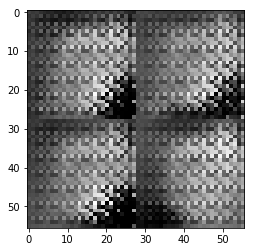

Epoch 2/2, iteration 680: Discriminator Loss: 1.2228, Generator Loss: 0.8655


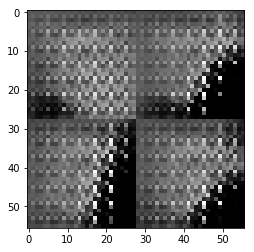

Epoch 2/2, iteration 690: Discriminator Loss: 1.0933, Generator Loss: 0.9568


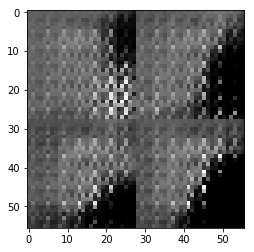

Epoch 2/2, iteration 700: Discriminator Loss: 1.3416, Generator Loss: 0.8331


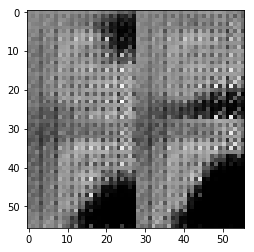

Epoch 2/2, iteration 710: Discriminator Loss: 1.6775, Generator Loss: 0.6744


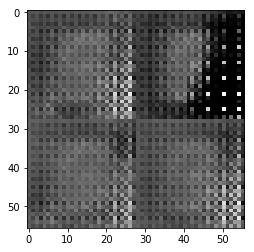

Epoch 2/2, iteration 720: Discriminator Loss: 1.7074, Generator Loss: 0.7015


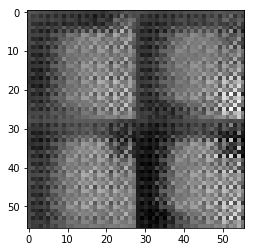

Epoch 2/2, iteration 730: Discriminator Loss: 1.6151, Generator Loss: 0.7012


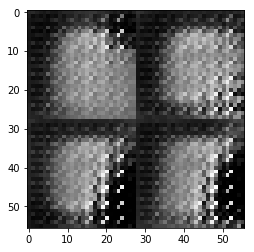

Epoch 2/2, iteration 740: Discriminator Loss: 1.3694, Generator Loss: 0.8007


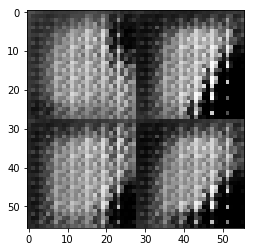

Epoch 2/2, iteration 750: Discriminator Loss: 1.3444, Generator Loss: 0.7795


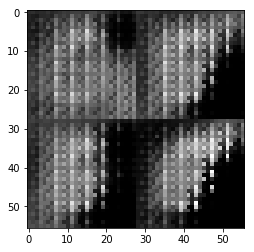

Epoch 2/2, iteration 760: Discriminator Loss: 1.4663, Generator Loss: 0.7608


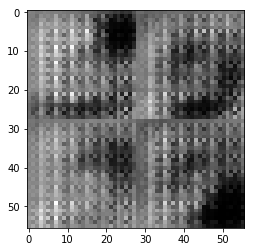

Epoch 2/2, iteration 770: Discriminator Loss: 1.3742, Generator Loss: 0.8138


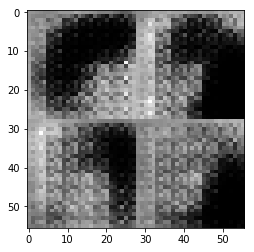

Epoch 2/2, iteration 780: Discriminator Loss: 1.3521, Generator Loss: 0.8349


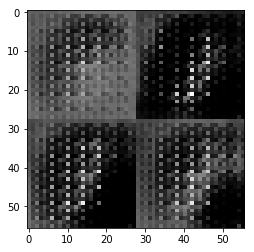

Epoch 2/2, iteration 790: Discriminator Loss: 1.6497, Generator Loss: 0.6949


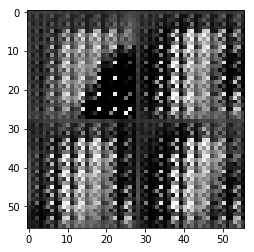

Epoch 2/2, iteration 800: Discriminator Loss: 1.3981, Generator Loss: 0.8243


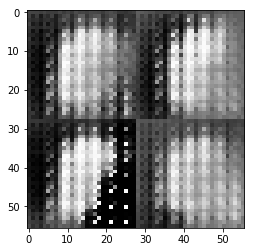

Epoch 2/2, iteration 810: Discriminator Loss: 0.9463, Generator Loss: 1.1400


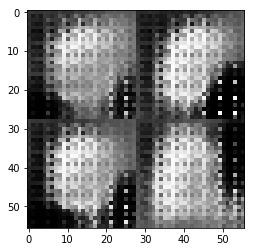

Epoch 2/2, iteration 820: Discriminator Loss: 1.7921, Generator Loss: 0.5836


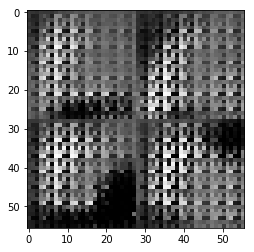

Epoch 2/2, iteration 830: Discriminator Loss: 1.4791, Generator Loss: 0.7621


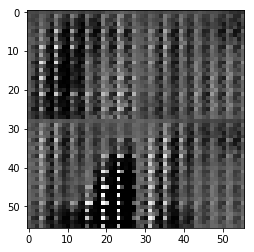

Epoch 2/2, iteration 840: Discriminator Loss: 1.1614, Generator Loss: 0.9953


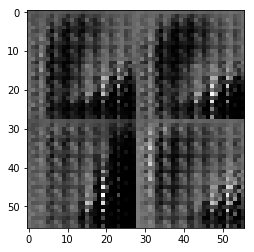

Epoch 2/2, iteration 850: Discriminator Loss: 1.0536, Generator Loss: 1.0790


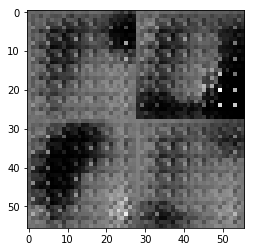

Epoch 2/2, iteration 860: Discriminator Loss: 1.6310, Generator Loss: 0.6379


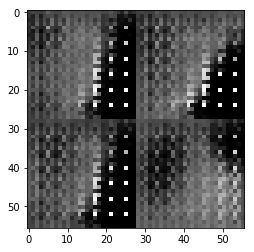

Epoch 2/2, iteration 870: Discriminator Loss: 1.5511, Generator Loss: 0.6882


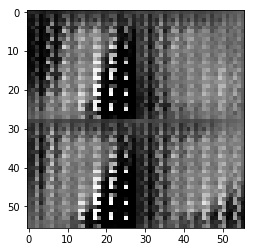

Epoch 2/2, iteration 880: Discriminator Loss: 1.3885, Generator Loss: 0.7792


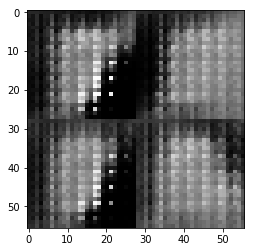

Epoch 2/2, iteration 890: Discriminator Loss: 1.4278, Generator Loss: 0.7938


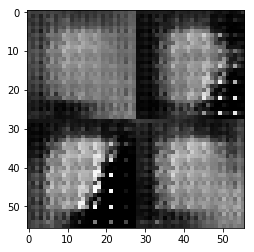

Epoch 2/2, iteration 900: Discriminator Loss: 1.4053, Generator Loss: 0.8292


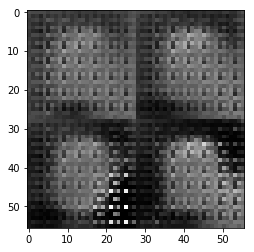

Epoch 2/2, iteration 910: Discriminator Loss: 1.4492, Generator Loss: 0.7763


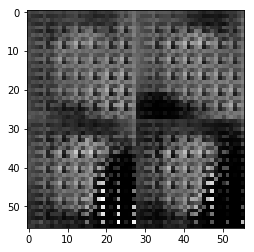

Epoch 2/2, iteration 920: Discriminator Loss: 1.4621, Generator Loss: 0.7353


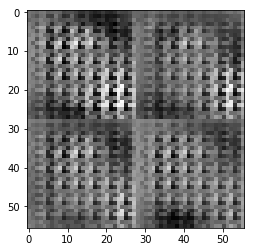

Epoch 2/2, iteration 930: Discriminator Loss: 1.1825, Generator Loss: 0.9098


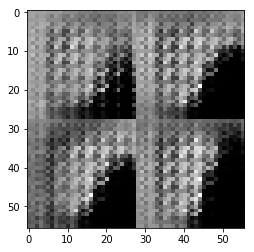

In [ ]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1, iteration 10: Discriminator Loss: 1.1022, Generator Loss: 0.8354


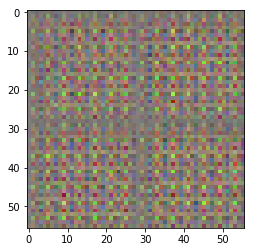

Epoch 1/1, iteration 20: Discriminator Loss: 1.1296, Generator Loss: 0.8962


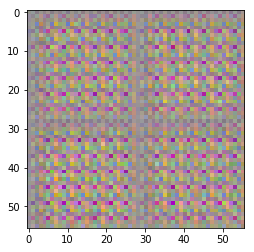

Epoch 1/1, iteration 30: Discriminator Loss: 2.0250, Generator Loss: 0.3122


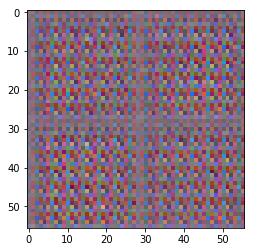

Epoch 1/1, iteration 40: Discriminator Loss: 1.3173, Generator Loss: 0.7852


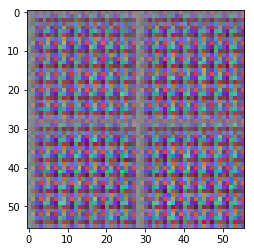

Epoch 1/1, iteration 50: Discriminator Loss: 2.0714, Generator Loss: 0.2520


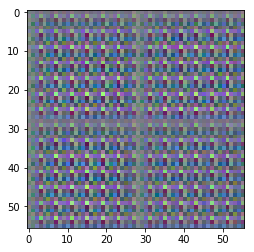

Epoch 1/1, iteration 60: Discriminator Loss: 2.1524, Generator Loss: 0.2126


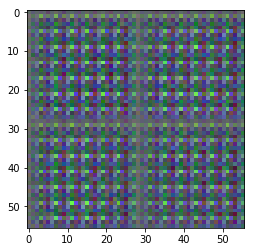

Epoch 1/1, iteration 70: Discriminator Loss: 1.5651, Generator Loss: 0.4063


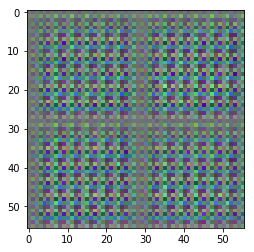

Epoch 1/1, iteration 80: Discriminator Loss: 2.1316, Generator Loss: 0.2117


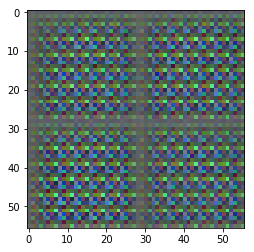

Epoch 1/1, iteration 90: Discriminator Loss: 1.7694, Generator Loss: 0.3335


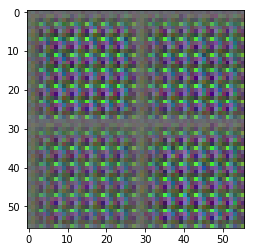

Epoch 1/1, iteration 100: Discriminator Loss: 1.5806, Generator Loss: 0.4026


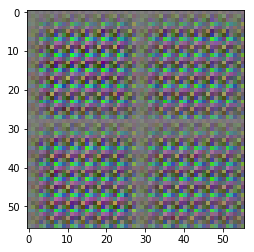

Epoch 1/1, iteration 110: Discriminator Loss: 1.4899, Generator Loss: 0.4456


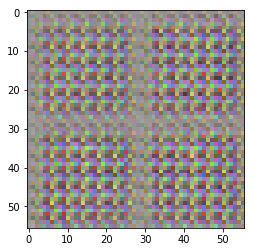

Epoch 1/1, iteration 120: Discriminator Loss: 2.0632, Generator Loss: 0.2570


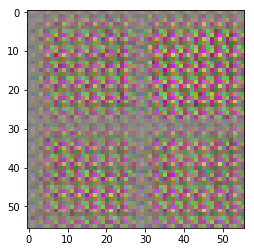

Epoch 1/1, iteration 130: Discriminator Loss: 2.3562, Generator Loss: 0.2338


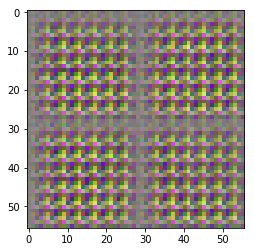

Epoch 1/1, iteration 140: Discriminator Loss: 2.2347, Generator Loss: 0.3220


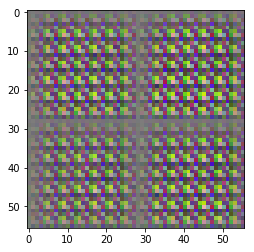

Epoch 1/1, iteration 150: Discriminator Loss: 2.0309, Generator Loss: 0.3805


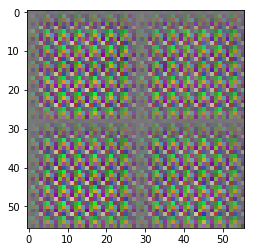

Epoch 1/1, iteration 160: Discriminator Loss: 2.1169, Generator Loss: 0.3255


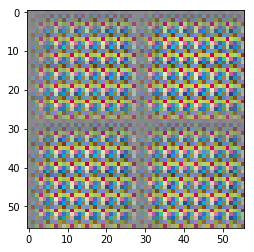

Epoch 1/1, iteration 170: Discriminator Loss: 1.7095, Generator Loss: 0.5188


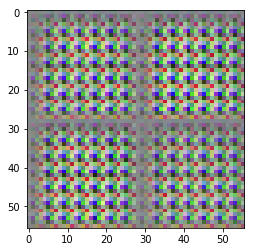

Epoch 1/1, iteration 180: Discriminator Loss: 2.4261, Generator Loss: 0.2358


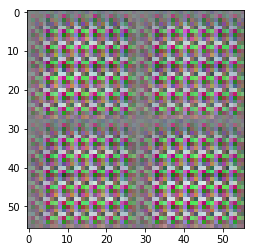

Epoch 1/1, iteration 190: Discriminator Loss: 2.5154, Generator Loss: 0.2368


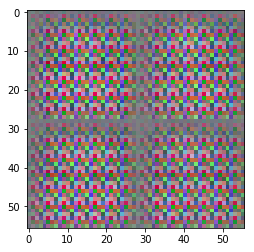

Epoch 1/1, iteration 200: Discriminator Loss: 1.8356, Generator Loss: 0.5331


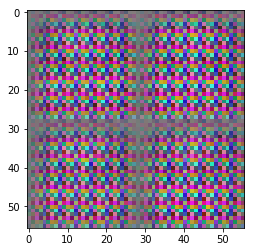

Epoch 1/1, iteration 210: Discriminator Loss: 1.7654, Generator Loss: 0.4764


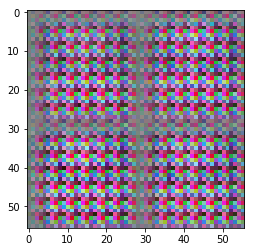

Epoch 1/1, iteration 220: Discriminator Loss: 2.4396, Generator Loss: 0.2702


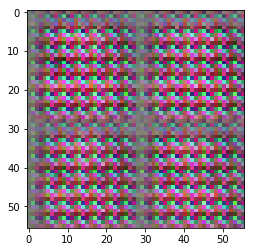

Epoch 1/1, iteration 230: Discriminator Loss: 2.3008, Generator Loss: 0.4550


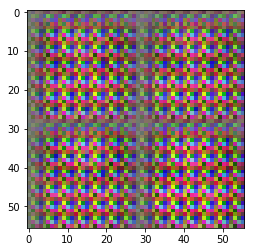

Epoch 1/1, iteration 240: Discriminator Loss: 2.5738, Generator Loss: 0.4087


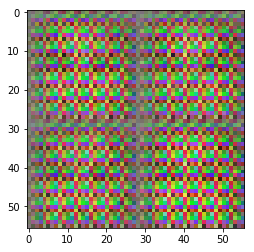

Epoch 1/1, iteration 250: Discriminator Loss: 2.4546, Generator Loss: 0.5368


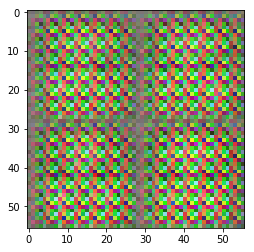

Epoch 1/1, iteration 260: Discriminator Loss: 2.1567, Generator Loss: 0.5955


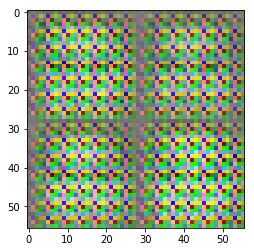

Epoch 1/1, iteration 270: Discriminator Loss: 1.7738, Generator Loss: 0.7710


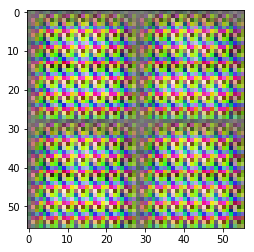

Epoch 1/1, iteration 280: Discriminator Loss: 2.0624, Generator Loss: 0.4777


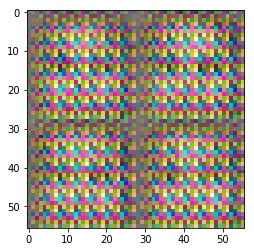

Epoch 1/1, iteration 290: Discriminator Loss: 2.4827, Generator Loss: 0.3894


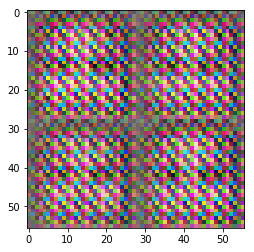

Epoch 1/1, iteration 300: Discriminator Loss: 2.2700, Generator Loss: 0.5472


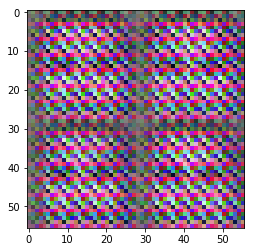

Epoch 1/1, iteration 310: Discriminator Loss: 2.0669, Generator Loss: 0.6548


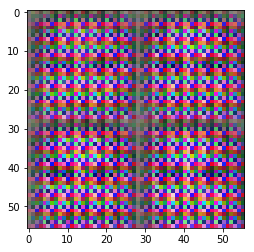

Epoch 1/1, iteration 320: Discriminator Loss: 1.6688, Generator Loss: 0.7918


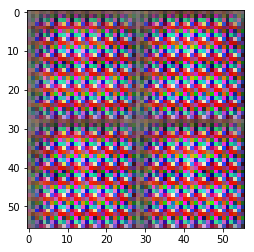

Epoch 1/1, iteration 330: Discriminator Loss: 2.0389, Generator Loss: 0.5198


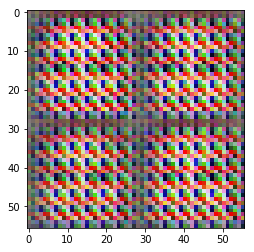

Epoch 1/1, iteration 340: Discriminator Loss: 2.1017, Generator Loss: 0.5082


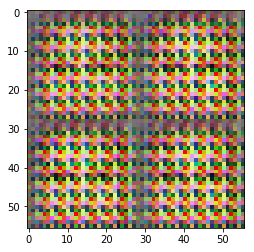

Epoch 1/1, iteration 350: Discriminator Loss: 1.9258, Generator Loss: 0.7331


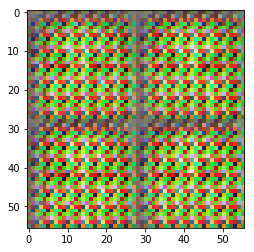

Epoch 1/1, iteration 360: Discriminator Loss: 1.6567, Generator Loss: 0.8714


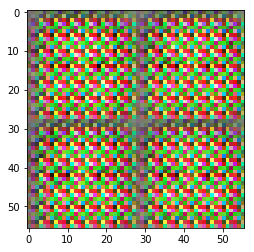

Epoch 1/1, iteration 370: Discriminator Loss: 1.9230, Generator Loss: 0.5049


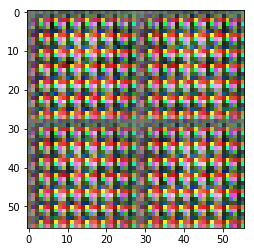

Epoch 1/1, iteration 380: Discriminator Loss: 1.7665, Generator Loss: 0.7909


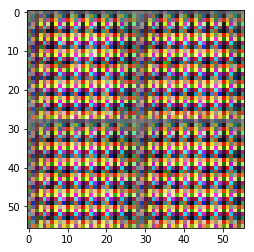

Epoch 1/1, iteration 390: Discriminator Loss: 1.7464, Generator Loss: 0.7504


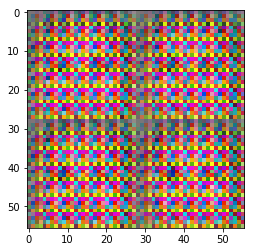

Epoch 1/1, iteration 400: Discriminator Loss: 1.6531, Generator Loss: 0.7106


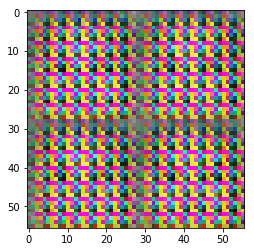

Epoch 1/1, iteration 410: Discriminator Loss: 1.3922, Generator Loss: 0.9925


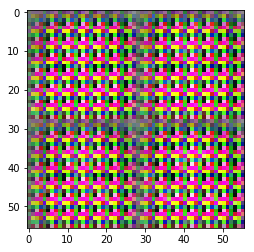

Epoch 1/1, iteration 420: Discriminator Loss: 1.4614, Generator Loss: 0.7725


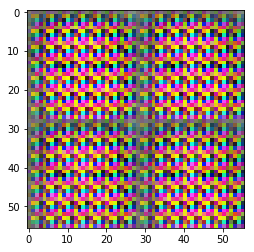

Epoch 1/1, iteration 430: Discriminator Loss: 1.6450, Generator Loss: 0.6514


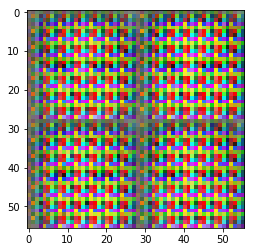

Epoch 1/1, iteration 440: Discriminator Loss: 1.9240, Generator Loss: 0.5889


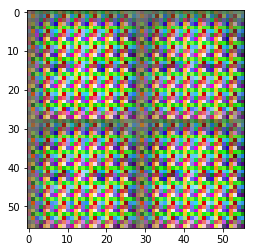

Epoch 1/1, iteration 450: Discriminator Loss: 2.0095, Generator Loss: 0.5401


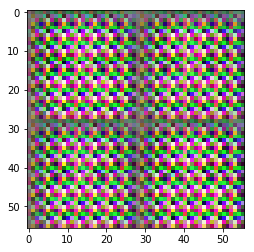

Epoch 1/1, iteration 460: Discriminator Loss: 1.7889, Generator Loss: 0.6779


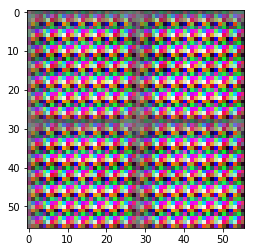

Epoch 1/1, iteration 470: Discriminator Loss: 1.7647, Generator Loss: 0.6505


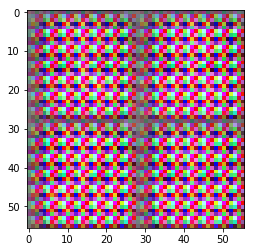

Epoch 1/1, iteration 480: Discriminator Loss: 1.2884, Generator Loss: 1.0541


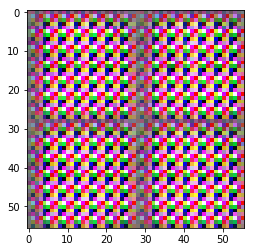

Epoch 1/1, iteration 490: Discriminator Loss: 1.4899, Generator Loss: 0.6777


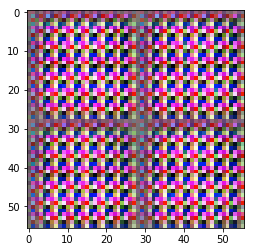

Epoch 1/1, iteration 500: Discriminator Loss: 1.6547, Generator Loss: 0.5480


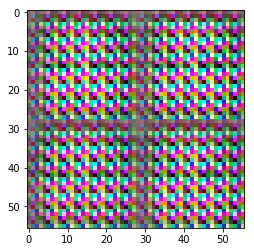

Epoch 1/1, iteration 510: Discriminator Loss: 1.6935, Generator Loss: 0.6168


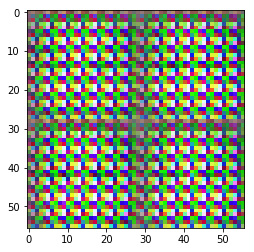

Epoch 1/1, iteration 520: Discriminator Loss: 1.7746, Generator Loss: 0.5552


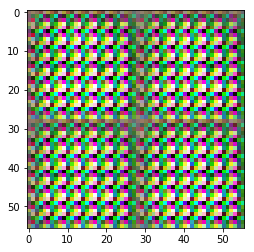

Epoch 1/1, iteration 530: Discriminator Loss: 1.6167, Generator Loss: 0.7037


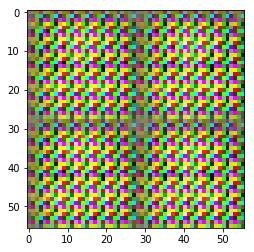

Epoch 1/1, iteration 540: Discriminator Loss: 1.8712, Generator Loss: 0.5319


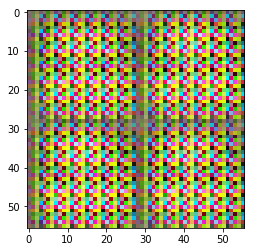

Epoch 1/1, iteration 550: Discriminator Loss: 2.0941, Generator Loss: 0.4880


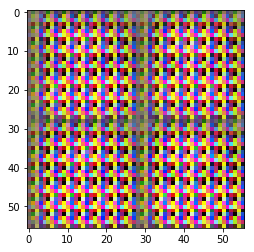

Epoch 1/1, iteration 560: Discriminator Loss: 2.0222, Generator Loss: 0.5228


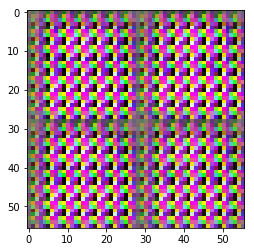

Epoch 1/1, iteration 570: Discriminator Loss: 2.1612, Generator Loss: 0.4139


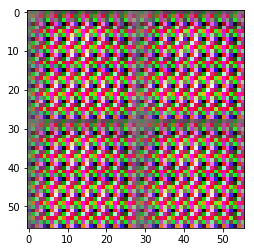

Epoch 1/1, iteration 580: Discriminator Loss: 2.4417, Generator Loss: 0.3093


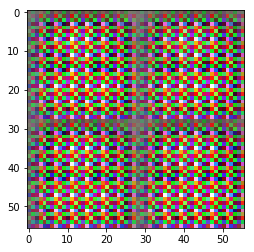

Epoch 1/1, iteration 590: Discriminator Loss: 2.0999, Generator Loss: 0.4956


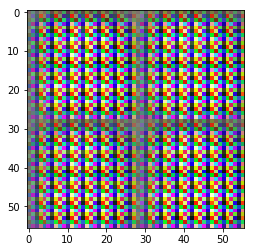

Epoch 1/1, iteration 600: Discriminator Loss: 1.7506, Generator Loss: 0.6090


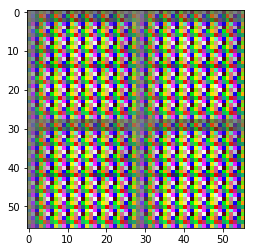

Epoch 1/1, iteration 610: Discriminator Loss: 1.5820, Generator Loss: 0.7075


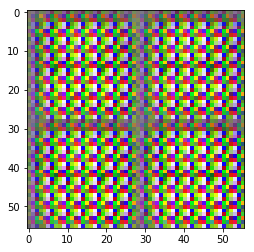

Epoch 1/1, iteration 620: Discriminator Loss: 1.6442, Generator Loss: 0.6608


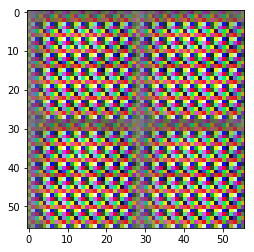

Epoch 1/1, iteration 630: Discriminator Loss: 1.6590, Generator Loss: 0.6125


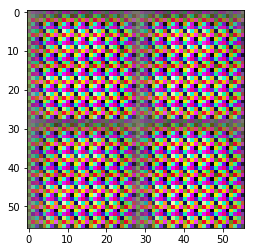

Epoch 1/1, iteration 640: Discriminator Loss: 2.0009, Generator Loss: 0.4708


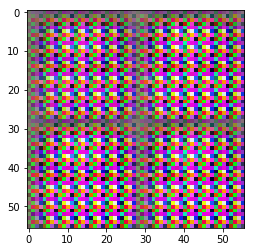

Epoch 1/1, iteration 650: Discriminator Loss: 1.9889, Generator Loss: 0.4871


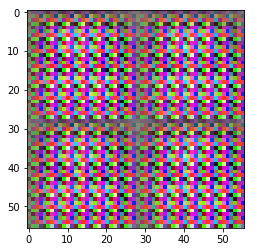

Epoch 1/1, iteration 660: Discriminator Loss: 1.7423, Generator Loss: 0.6772


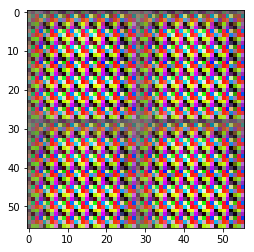

Epoch 1/1, iteration 670: Discriminator Loss: 1.5940, Generator Loss: 0.8145


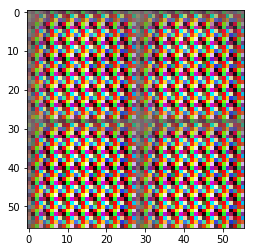

Epoch 1/1, iteration 680: Discriminator Loss: 1.8754, Generator Loss: 0.5513


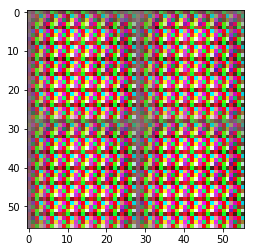

Epoch 1/1, iteration 690: Discriminator Loss: 2.2031, Generator Loss: 0.4562


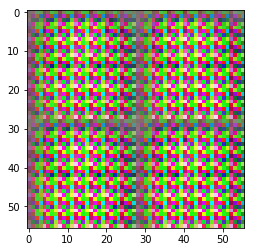

Epoch 1/1, iteration 700: Discriminator Loss: 2.0378, Generator Loss: 0.5297


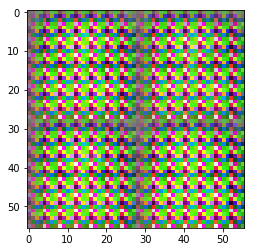

Epoch 1/1, iteration 710: Discriminator Loss: 2.0805, Generator Loss: 0.4630


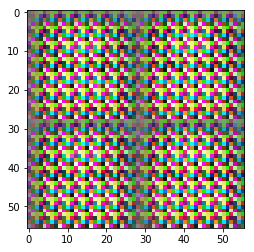

Epoch 1/1, iteration 720: Discriminator Loss: 2.2140, Generator Loss: 0.4435


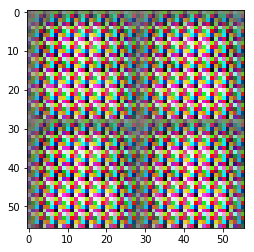

Epoch 1/1, iteration 730: Discriminator Loss: 2.4245, Generator Loss: 0.4219


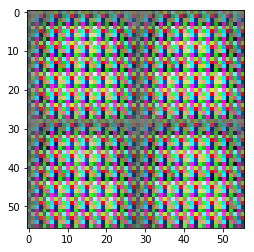

Epoch 1/1, iteration 740: Discriminator Loss: 2.4924, Generator Loss: 0.3322


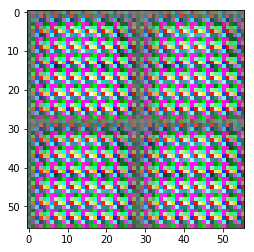

Epoch 1/1, iteration 750: Discriminator Loss: 1.9702, Generator Loss: 0.5048


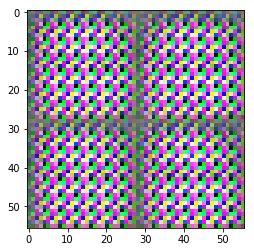

Epoch 1/1, iteration 760: Discriminator Loss: 1.4183, Generator Loss: 0.8130


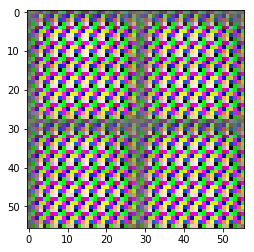

Epoch 1/1, iteration 770: Discriminator Loss: 1.5482, Generator Loss: 0.6969


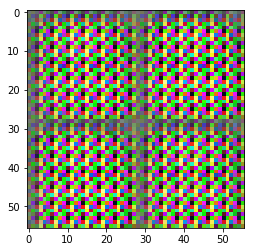

Epoch 1/1, iteration 780: Discriminator Loss: 1.6868, Generator Loss: 0.6123


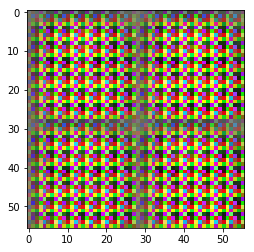

Epoch 1/1, iteration 790: Discriminator Loss: 1.8108, Generator Loss: 0.5897


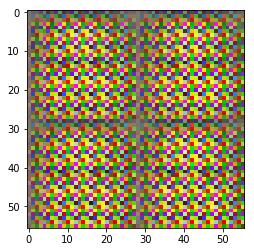

Epoch 1/1, iteration 800: Discriminator Loss: 1.8792, Generator Loss: 0.5781


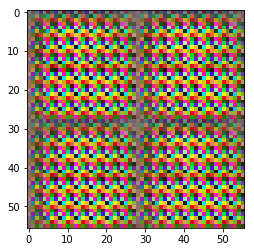

Epoch 1/1, iteration 810: Discriminator Loss: 2.2159, Generator Loss: 0.4902


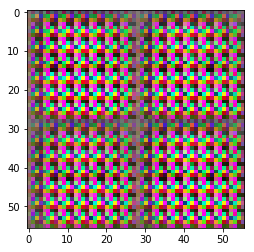

Epoch 1/1, iteration 820: Discriminator Loss: 2.2571, Generator Loss: 0.4808


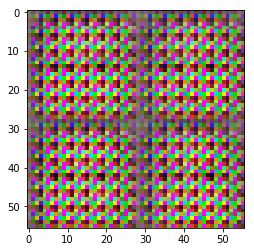

Epoch 1/1, iteration 830: Discriminator Loss: 2.4057, Generator Loss: 0.3991


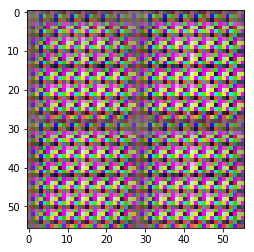

Epoch 1/1, iteration 840: Discriminator Loss: 2.3243, Generator Loss: 0.4228


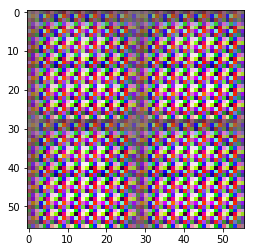

Epoch 1/1, iteration 850: Discriminator Loss: 1.7945, Generator Loss: 0.6502


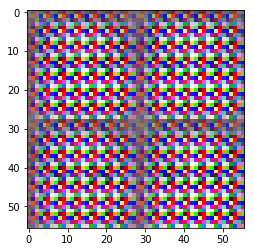

Epoch 1/1, iteration 860: Discriminator Loss: 1.6435, Generator Loss: 0.6552


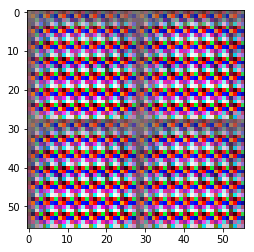

Epoch 1/1, iteration 870: Discriminator Loss: 1.6641, Generator Loss: 0.6313


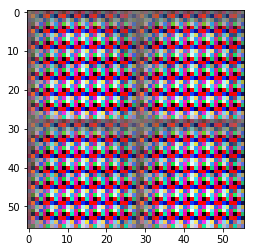

Epoch 1/1, iteration 880: Discriminator Loss: 1.6832, Generator Loss: 0.5333


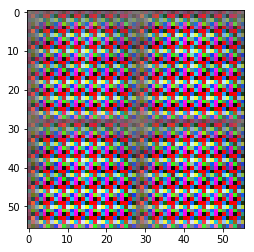

Epoch 1/1, iteration 890: Discriminator Loss: 2.0522, Generator Loss: 0.4801


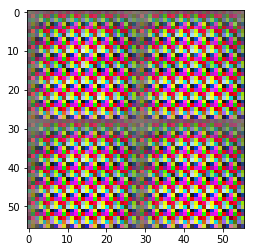

Epoch 1/1, iteration 900: Discriminator Loss: 1.7635, Generator Loss: 0.7266


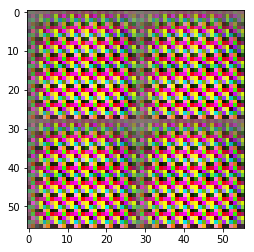

Epoch 1/1, iteration 910: Discriminator Loss: 2.0787, Generator Loss: 0.4700


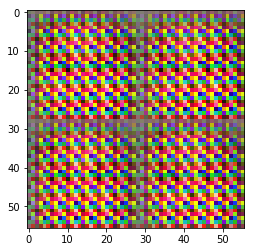

Epoch 1/1, iteration 920: Discriminator Loss: 2.0976, Generator Loss: 0.5456


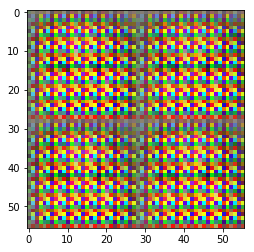

Epoch 1/1, iteration 930: Discriminator Loss: 2.0914, Generator Loss: 0.5794


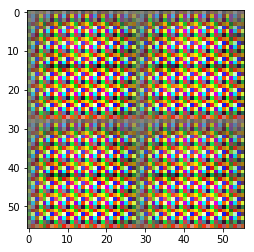

Epoch 1/1, iteration 940: Discriminator Loss: 1.9475, Generator Loss: 0.5824


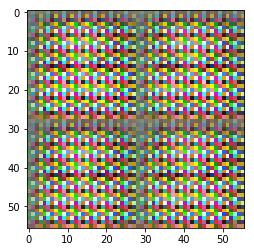

Epoch 1/1, iteration 950: Discriminator Loss: 2.4589, Generator Loss: 0.3086


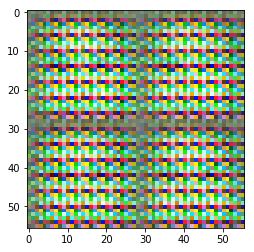

Epoch 1/1, iteration 960: Discriminator Loss: 1.9684, Generator Loss: 0.5703


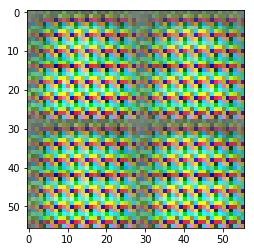

Epoch 1/1, iteration 970: Discriminator Loss: 2.4982, Generator Loss: 0.3146


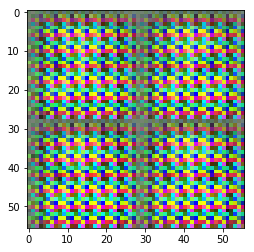

Epoch 1/1, iteration 980: Discriminator Loss: 2.1265, Generator Loss: 0.5155


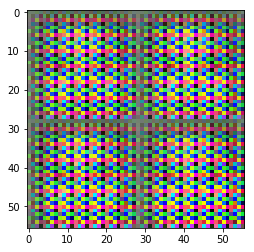

Epoch 1/1, iteration 990: Discriminator Loss: 1.7232, Generator Loss: 0.8844


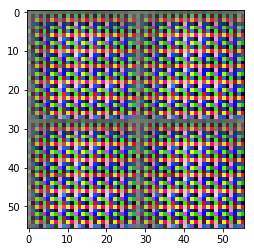

Epoch 1/1, iteration 1000: Discriminator Loss: 1.7516, Generator Loss: 0.6525


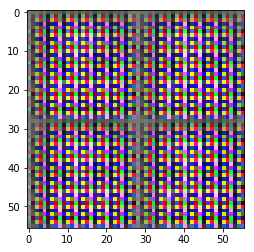

Epoch 1/1, iteration 1010: Discriminator Loss: 1.6284, Generator Loss: 0.7801


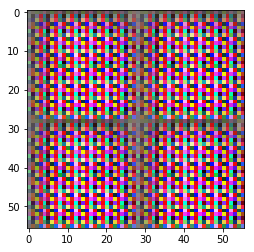

Epoch 1/1, iteration 1020: Discriminator Loss: 1.8034, Generator Loss: 0.5751


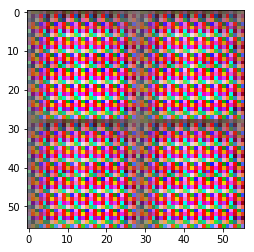

Epoch 1/1, iteration 1030: Discriminator Loss: 1.8358, Generator Loss: 0.6040


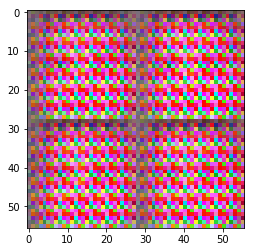

Epoch 1/1, iteration 1040: Discriminator Loss: 1.9600, Generator Loss: 0.5761


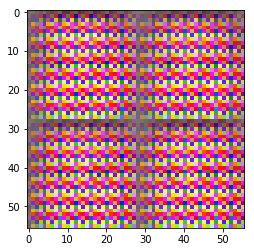

Epoch 1/1, iteration 1050: Discriminator Loss: 2.1232, Generator Loss: 0.4917


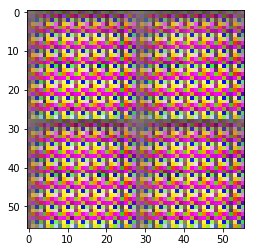

Epoch 1/1, iteration 1060: Discriminator Loss: 2.3572, Generator Loss: 0.4034


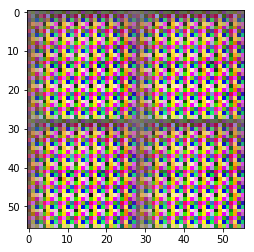

Epoch 1/1, iteration 1070: Discriminator Loss: 1.9436, Generator Loss: 0.8444


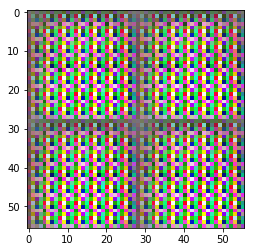

Epoch 1/1, iteration 1080: Discriminator Loss: 2.0734, Generator Loss: 0.4689


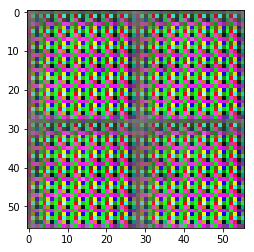

Epoch 1/1, iteration 1090: Discriminator Loss: 1.5144, Generator Loss: 0.9191


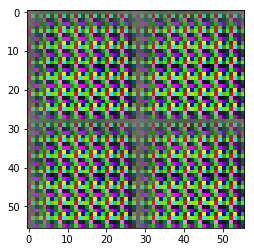

Epoch 1/1, iteration 1100: Discriminator Loss: 1.8651, Generator Loss: 0.5149


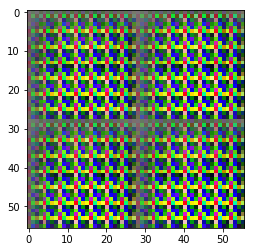

Epoch 1/1, iteration 1110: Discriminator Loss: 1.3035, Generator Loss: 1.0028


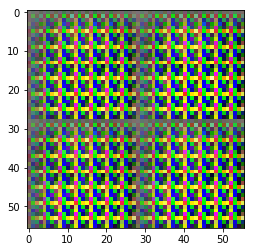

Epoch 1/1, iteration 1120: Discriminator Loss: 1.6849, Generator Loss: 0.5377


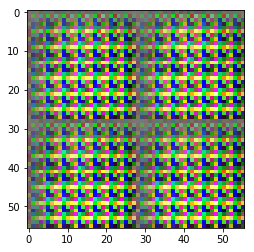

Epoch 1/1, iteration 1130: Discriminator Loss: 1.6309, Generator Loss: 0.6530


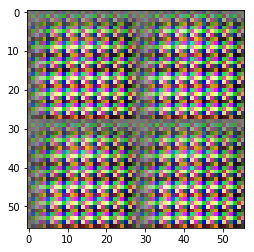

Epoch 1/1, iteration 1140: Discriminator Loss: 1.7253, Generator Loss: 0.5570


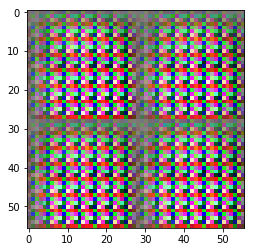

Epoch 1/1, iteration 1150: Discriminator Loss: 2.4026, Generator Loss: 0.2868


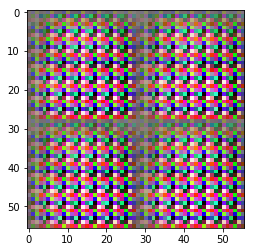

Epoch 1/1, iteration 1160: Discriminator Loss: 2.3685, Generator Loss: 0.3533


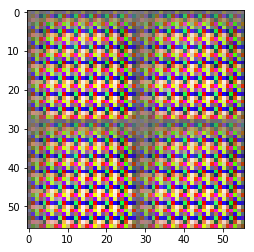

Epoch 1/1, iteration 1170: Discriminator Loss: 1.7145, Generator Loss: 0.7644


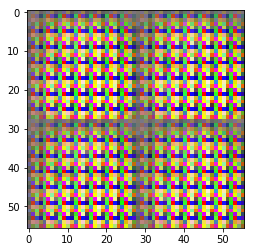

Epoch 1/1, iteration 1180: Discriminator Loss: 1.9572, Generator Loss: 0.4892


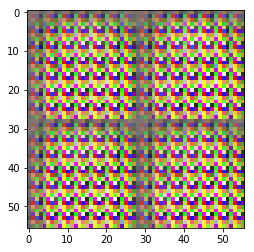

Epoch 1/1, iteration 1190: Discriminator Loss: 1.6200, Generator Loss: 0.7643


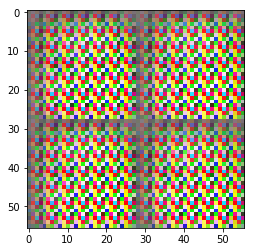

Epoch 1/1, iteration 1200: Discriminator Loss: 2.0051, Generator Loss: 0.4534


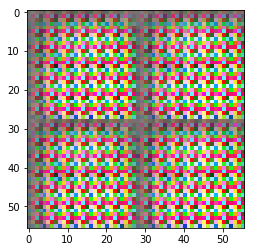

Epoch 1/1, iteration 1210: Discriminator Loss: 1.7636, Generator Loss: 0.6588


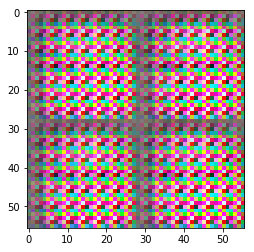

Epoch 1/1, iteration 1220: Discriminator Loss: 2.2456, Generator Loss: 0.3931


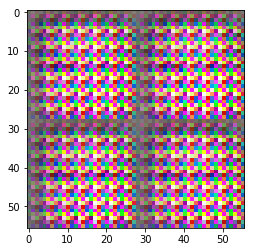

Epoch 1/1, iteration 1230: Discriminator Loss: 1.8324, Generator Loss: 0.7574


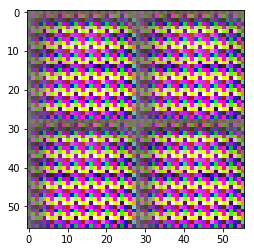

Epoch 1/1, iteration 1240: Discriminator Loss: 1.6631, Generator Loss: 0.7480


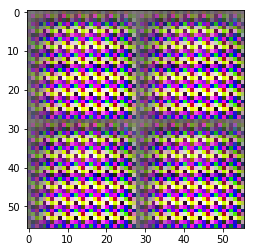

Epoch 1/1, iteration 1250: Discriminator Loss: 1.7402, Generator Loss: 0.6264


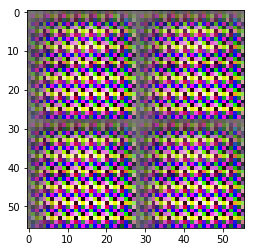

Epoch 1/1, iteration 1260: Discriminator Loss: 1.8462, Generator Loss: 0.6324


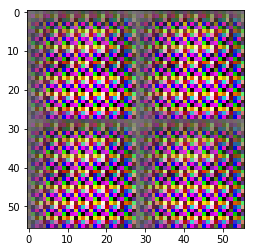

Epoch 1/1, iteration 1270: Discriminator Loss: 2.0380, Generator Loss: 0.4797


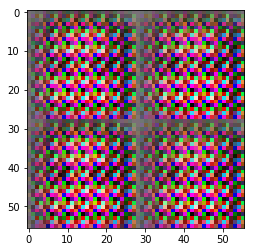

Epoch 1/1, iteration 1280: Discriminator Loss: 2.2545, Generator Loss: 0.4708


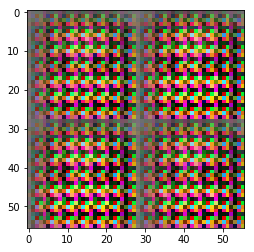

Epoch 1/1, iteration 1290: Discriminator Loss: 2.5217, Generator Loss: 0.3689


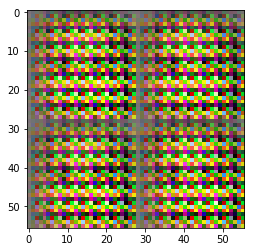

Epoch 1/1, iteration 1300: Discriminator Loss: 2.4117, Generator Loss: 0.5123


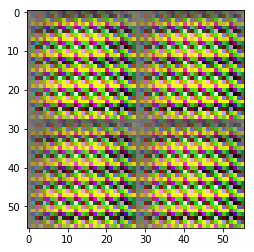

Epoch 1/1, iteration 1310: Discriminator Loss: 2.1869, Generator Loss: 0.6114


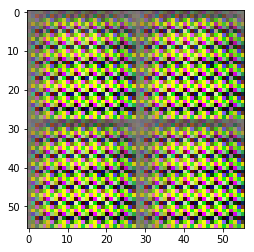

Epoch 1/1, iteration 1320: Discriminator Loss: 1.5783, Generator Loss: 0.9603


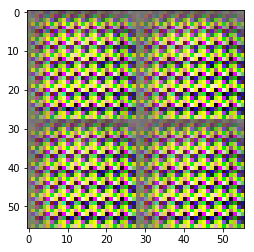

Epoch 1/1, iteration 1330: Discriminator Loss: 1.7517, Generator Loss: 0.6098


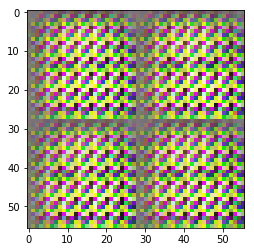

Epoch 1/1, iteration 1340: Discriminator Loss: 2.1178, Generator Loss: 0.4047


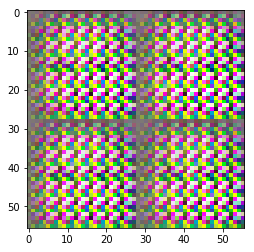

Epoch 1/1, iteration 1350: Discriminator Loss: 1.4481, Generator Loss: 0.8909


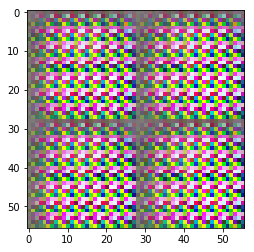

Epoch 1/1, iteration 1360: Discriminator Loss: 1.5467, Generator Loss: 0.8304


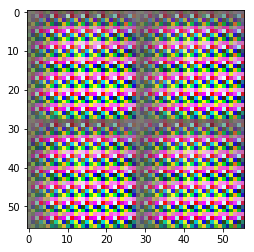

Epoch 1/1, iteration 1370: Discriminator Loss: 1.9433, Generator Loss: 0.4639


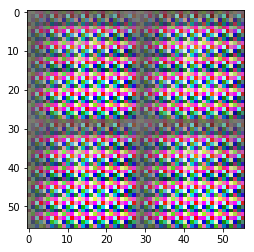

Epoch 1/1, iteration 1380: Discriminator Loss: 1.8374, Generator Loss: 0.6160


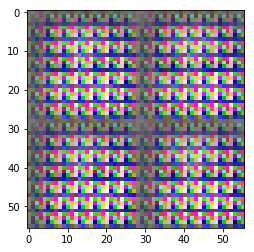

Epoch 1/1, iteration 1390: Discriminator Loss: 1.7839, Generator Loss: 0.6873


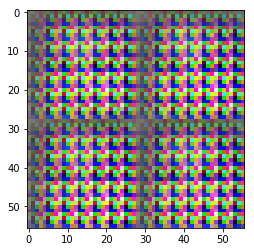

Epoch 1/1, iteration 1400: Discriminator Loss: 1.4535, Generator Loss: 0.9309


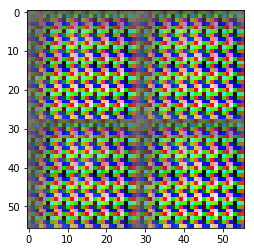

Epoch 1/1, iteration 1410: Discriminator Loss: 1.6581, Generator Loss: 0.6211


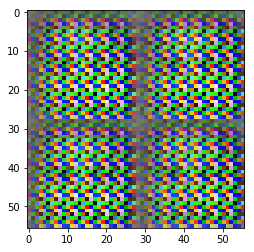

Epoch 1/1, iteration 1420: Discriminator Loss: 1.8164, Generator Loss: 0.5824


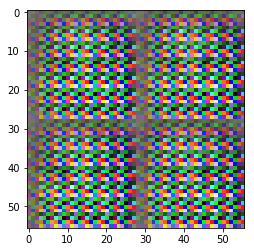

Epoch 1/1, iteration 1430: Discriminator Loss: 1.8980, Generator Loss: 0.4829


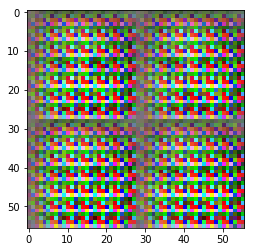

Epoch 1/1, iteration 1440: Discriminator Loss: 1.9473, Generator Loss: 0.4972


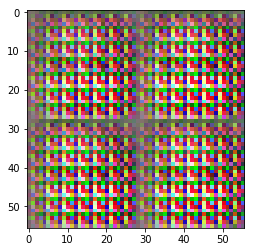

Epoch 1/1, iteration 1450: Discriminator Loss: 2.4443, Generator Loss: 0.2958


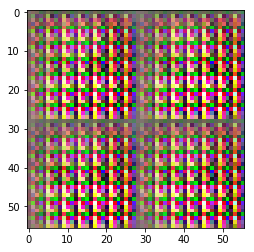

Epoch 1/1, iteration 1460: Discriminator Loss: 1.9578, Generator Loss: 0.5953


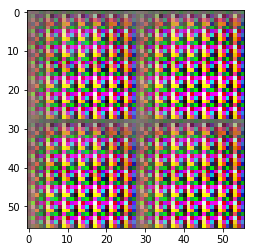

Epoch 1/1, iteration 1470: Discriminator Loss: 1.4244, Generator Loss: 0.9067


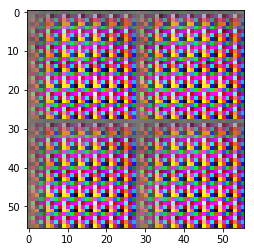

Epoch 1/1, iteration 1480: Discriminator Loss: 1.6939, Generator Loss: 0.5382


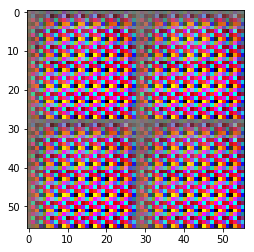

Epoch 1/1, iteration 1490: Discriminator Loss: 1.5162, Generator Loss: 0.7103


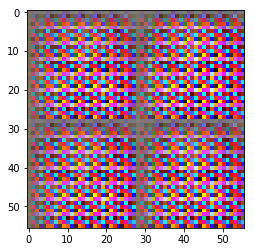

Epoch 1/1, iteration 1500: Discriminator Loss: 1.7158, Generator Loss: 0.5258


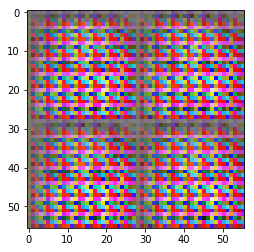

Epoch 1/1, iteration 1510: Discriminator Loss: 1.9268, Generator Loss: 0.4638


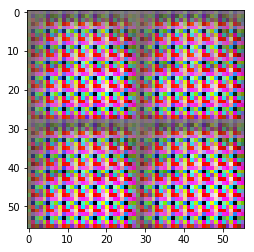

Epoch 1/1, iteration 1520: Discriminator Loss: 1.6906, Generator Loss: 0.6663


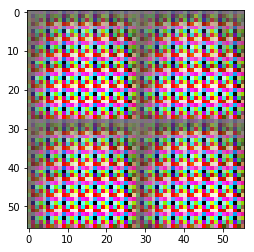

Epoch 1/1, iteration 1530: Discriminator Loss: 1.6690, Generator Loss: 0.6661


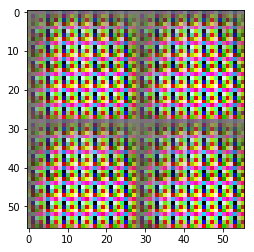

Epoch 1/1, iteration 1540: Discriminator Loss: 2.0136, Generator Loss: 0.4844


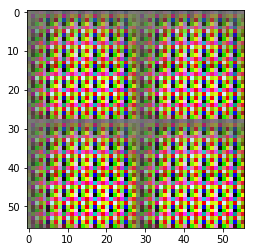

Epoch 1/1, iteration 1550: Discriminator Loss: 1.5483, Generator Loss: 0.8697


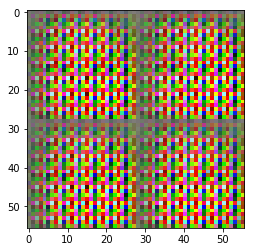

Epoch 1/1, iteration 1560: Discriminator Loss: 2.0747, Generator Loss: 0.3988


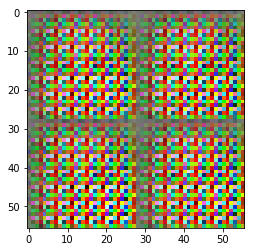

Epoch 1/1, iteration 1570: Discriminator Loss: 1.4765, Generator Loss: 0.9639


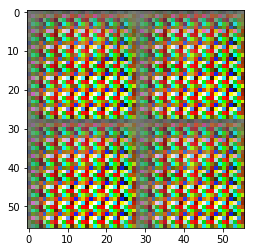

Epoch 1/1, iteration 1580: Discriminator Loss: 1.7455, Generator Loss: 0.5950


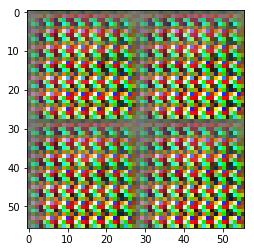

Epoch 1/1, iteration 1590: Discriminator Loss: 2.2504, Generator Loss: 0.3759


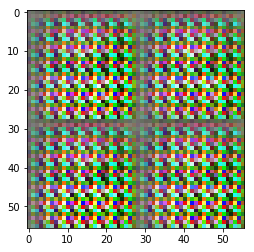

Epoch 1/1, iteration 1600: Discriminator Loss: 2.2093, Generator Loss: 0.4831


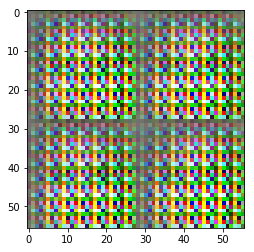

Epoch 1/1, iteration 1610: Discriminator Loss: 2.1725, Generator Loss: 0.4810


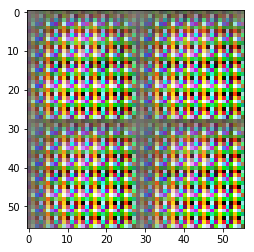

Epoch 1/1, iteration 1620: Discriminator Loss: 1.8489, Generator Loss: 0.6507


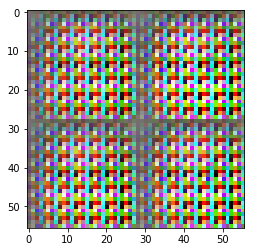

Epoch 1/1, iteration 1630: Discriminator Loss: 1.7775, Generator Loss: 0.5897


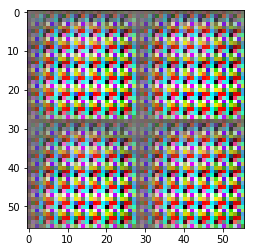

Epoch 1/1, iteration 1640: Discriminator Loss: 2.2854, Generator Loss: 0.3262


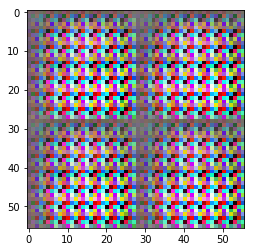

Epoch 1/1, iteration 1650: Discriminator Loss: 1.8136, Generator Loss: 0.6796


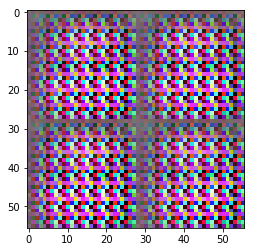

Epoch 1/1, iteration 1660: Discriminator Loss: 1.7571, Generator Loss: 0.5948


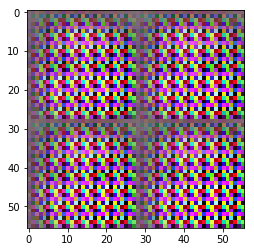

Epoch 1/1, iteration 1670: Discriminator Loss: 1.6807, Generator Loss: 0.6727


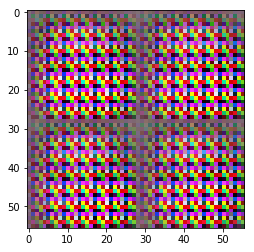

Epoch 1/1, iteration 1680: Discriminator Loss: 1.7236, Generator Loss: 0.6377


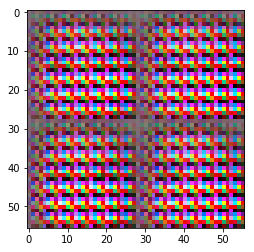

Epoch 1/1, iteration 1690: Discriminator Loss: 1.6130, Generator Loss: 0.7279


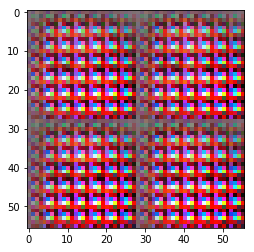

Epoch 1/1, iteration 1700: Discriminator Loss: 1.8414, Generator Loss: 0.5902


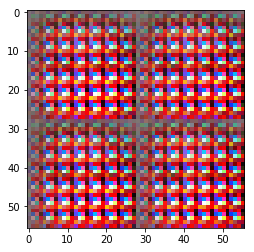

Epoch 1/1, iteration 1710: Discriminator Loss: 1.8692, Generator Loss: 0.6021


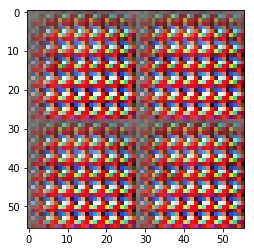

Epoch 1/1, iteration 1720: Discriminator Loss: 2.2846, Generator Loss: 0.4632


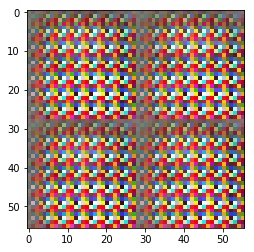

Epoch 1/1, iteration 1730: Discriminator Loss: 1.9850, Generator Loss: 0.6156


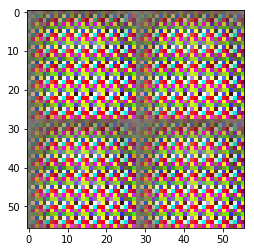

Epoch 1/1, iteration 1740: Discriminator Loss: 1.7106, Generator Loss: 0.7549


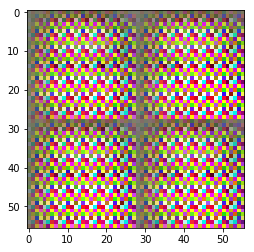

Epoch 1/1, iteration 1750: Discriminator Loss: 1.8336, Generator Loss: 0.5988


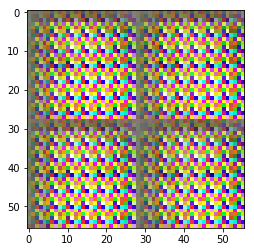

Epoch 1/1, iteration 1760: Discriminator Loss: 2.2083, Generator Loss: 0.3985


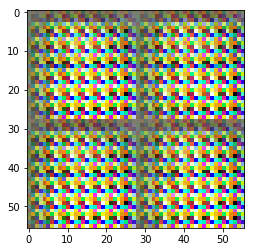

Epoch 1/1, iteration 1770: Discriminator Loss: 2.0376, Generator Loss: 0.5706


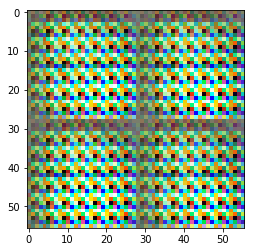

Epoch 1/1, iteration 1780: Discriminator Loss: 1.9338, Generator Loss: 0.5499


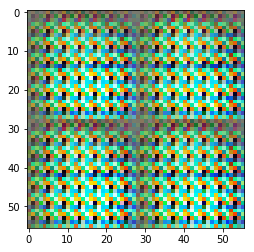

Epoch 1/1, iteration 1790: Discriminator Loss: 1.9005, Generator Loss: 0.6062


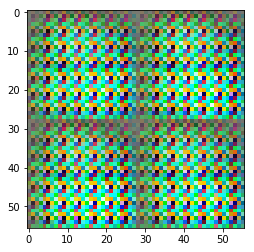

Epoch 1/1, iteration 1800: Discriminator Loss: 1.8057, Generator Loss: 0.6029


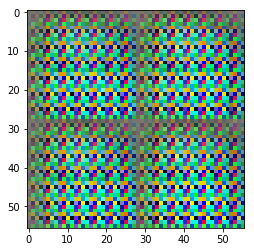

Epoch 1/1, iteration 1810: Discriminator Loss: 1.6554, Generator Loss: 0.6766


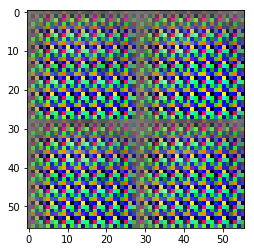

Epoch 1/1, iteration 1820: Discriminator Loss: 1.6558, Generator Loss: 0.6470


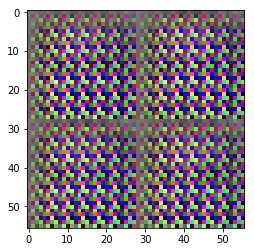

Epoch 1/1, iteration 1830: Discriminator Loss: 1.8114, Generator Loss: 0.5185


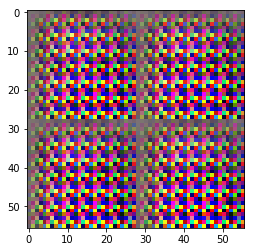

Epoch 1/1, iteration 1840: Discriminator Loss: 1.8865, Generator Loss: 0.5133


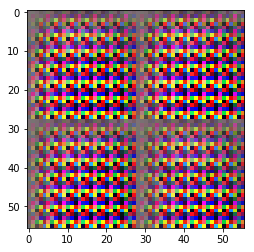

Epoch 1/1, iteration 1850: Discriminator Loss: 1.7282, Generator Loss: 0.6219


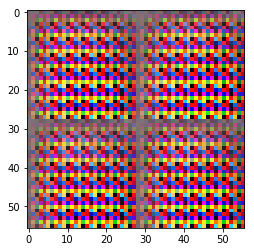

Epoch 1/1, iteration 1860: Discriminator Loss: 1.7295, Generator Loss: 0.6893


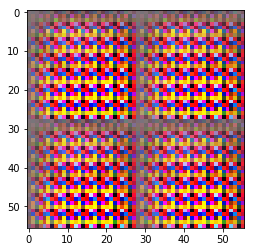

Epoch 1/1, iteration 1870: Discriminator Loss: 1.7051, Generator Loss: 0.5901


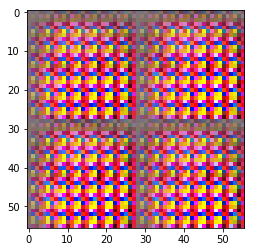

Epoch 1/1, iteration 1880: Discriminator Loss: 1.4519, Generator Loss: 0.8131


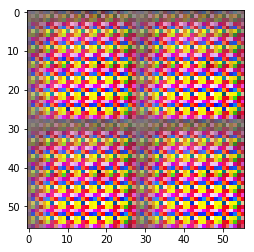

Epoch 1/1, iteration 1890: Discriminator Loss: 1.6461, Generator Loss: 0.6394


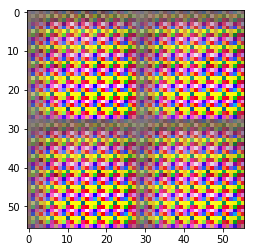

Epoch 1/1, iteration 1900: Discriminator Loss: 2.1821, Generator Loss: 0.3539


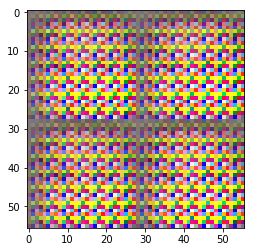

Epoch 1/1, iteration 1910: Discriminator Loss: 1.8871, Generator Loss: 0.5620


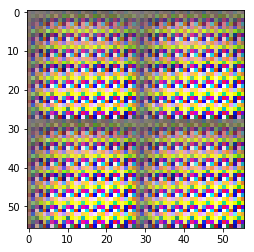

Epoch 1/1, iteration 1920: Discriminator Loss: 1.9304, Generator Loss: 0.5861


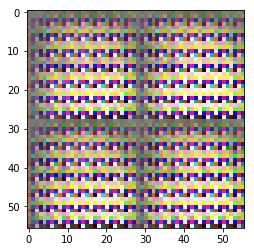

Epoch 1/1, iteration 1930: Discriminator Loss: 1.9047, Generator Loss: 0.5752


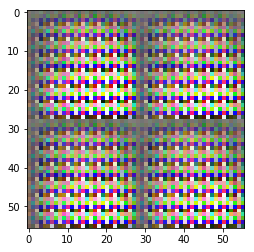

Epoch 1/1, iteration 1940: Discriminator Loss: 2.0324, Generator Loss: 0.5069


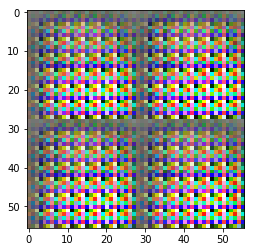

Epoch 1/1, iteration 1950: Discriminator Loss: 2.0963, Generator Loss: 0.5071


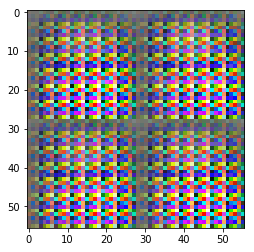

Epoch 1/1, iteration 1960: Discriminator Loss: 2.2774, Generator Loss: 0.4431


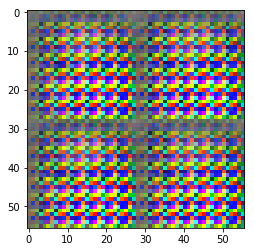

Epoch 1/1, iteration 1970: Discriminator Loss: 2.1074, Generator Loss: 0.5175


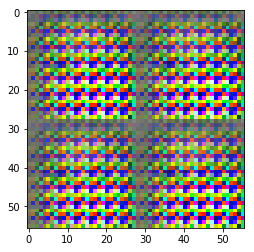

Epoch 1/1, iteration 1980: Discriminator Loss: 2.0640, Generator Loss: 0.5295


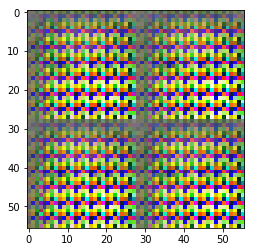

Epoch 1/1, iteration 1990: Discriminator Loss: 1.8189, Generator Loss: 0.7080


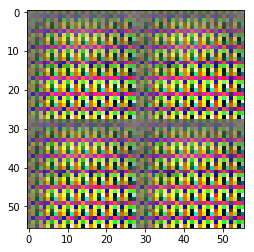

Epoch 1/1, iteration 2000: Discriminator Loss: 1.5130, Generator Loss: 0.9149


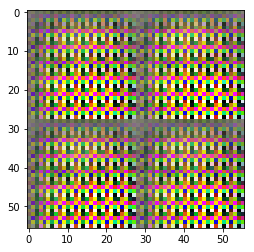

Epoch 1/1, iteration 2010: Discriminator Loss: 1.4644, Generator Loss: 0.7912


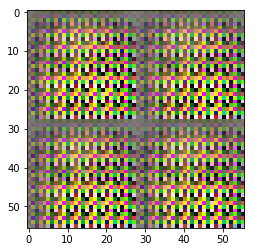

Epoch 1/1, iteration 2020: Discriminator Loss: 1.8072, Generator Loss: 0.5472


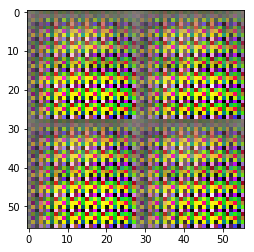

Epoch 1/1, iteration 2030: Discriminator Loss: 1.6669, Generator Loss: 0.7140


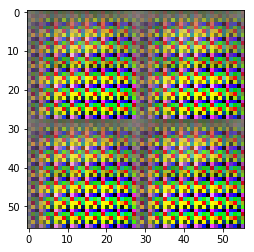

Epoch 1/1, iteration 2040: Discriminator Loss: 1.6924, Generator Loss: 0.6817


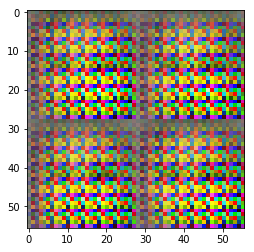

Epoch 1/1, iteration 2050: Discriminator Loss: 1.7618, Generator Loss: 0.6388


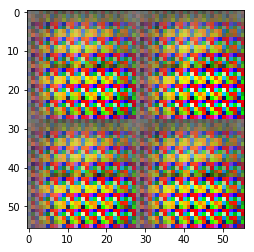

Epoch 1/1, iteration 2060: Discriminator Loss: 1.9921, Generator Loss: 0.5095


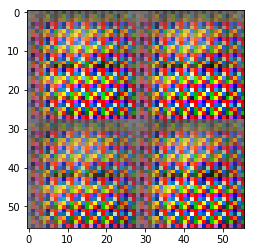

Epoch 1/1, iteration 2070: Discriminator Loss: 1.9071, Generator Loss: 0.6112


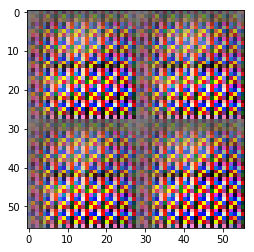

Epoch 1/1, iteration 2080: Discriminator Loss: 1.7432, Generator Loss: 0.7333


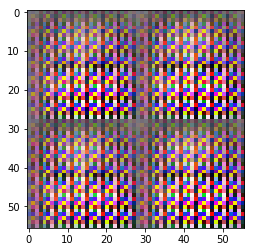

Epoch 1/1, iteration 2090: Discriminator Loss: 1.8440, Generator Loss: 0.5911


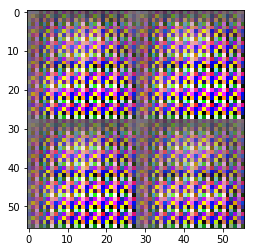

Epoch 1/1, iteration 2100: Discriminator Loss: 1.9019, Generator Loss: 0.5474


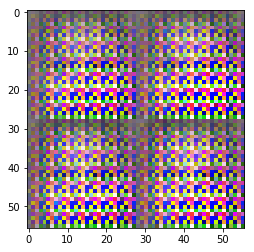

Epoch 1/1, iteration 2110: Discriminator Loss: 1.6503, Generator Loss: 0.7887


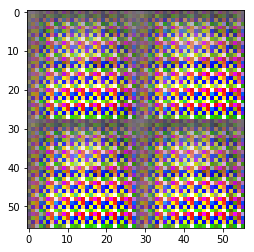

Epoch 1/1, iteration 2120: Discriminator Loss: 1.6570, Generator Loss: 0.7467


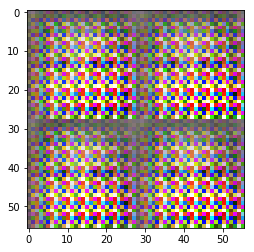

Epoch 1/1, iteration 2130: Discriminator Loss: 1.6266, Generator Loss: 0.7655


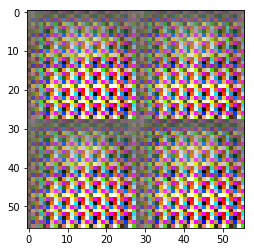

Epoch 1/1, iteration 2140: Discriminator Loss: 1.5733, Generator Loss: 0.8299


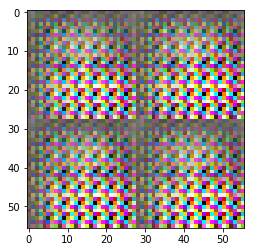

Epoch 1/1, iteration 2150: Discriminator Loss: 2.0019, Generator Loss: 0.4717


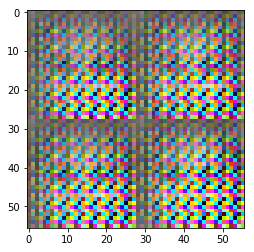

Epoch 1/1, iteration 2160: Discriminator Loss: 1.8410, Generator Loss: 0.6623


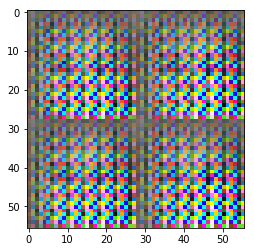

Epoch 1/1, iteration 2170: Discriminator Loss: 1.6702, Generator Loss: 0.6633


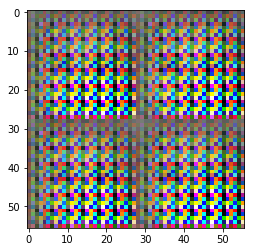

Epoch 1/1, iteration 2180: Discriminator Loss: 1.6984, Generator Loss: 0.5999


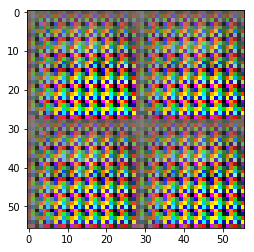

Epoch 1/1, iteration 2190: Discriminator Loss: 1.5509, Generator Loss: 0.7311


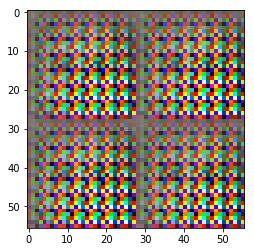

Epoch 1/1, iteration 2200: Discriminator Loss: 1.4675, Generator Loss: 0.7400


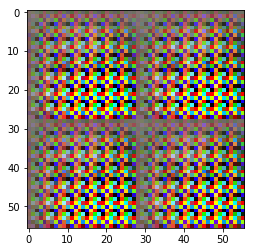

Epoch 1/1, iteration 2210: Discriminator Loss: 1.7113, Generator Loss: 0.5538


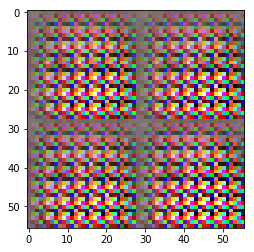

Epoch 1/1, iteration 2220: Discriminator Loss: 1.5731, Generator Loss: 0.6492


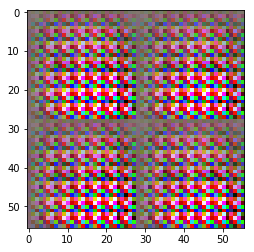

Epoch 1/1, iteration 2230: Discriminator Loss: 1.2408, Generator Loss: 0.9245


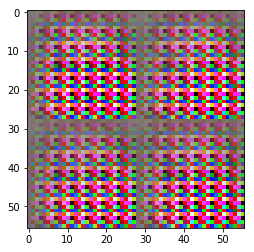

Epoch 1/1, iteration 2240: Discriminator Loss: 1.3334, Generator Loss: 0.7746


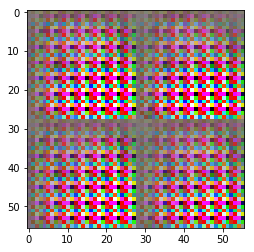

Epoch 1/1, iteration 2250: Discriminator Loss: 1.5240, Generator Loss: 0.6397


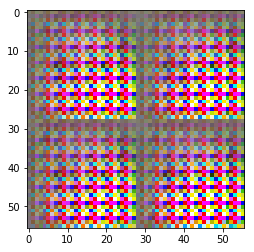

Epoch 1/1, iteration 2260: Discriminator Loss: 1.6948, Generator Loss: 0.5297


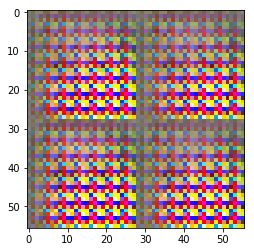

Epoch 1/1, iteration 2270: Discriminator Loss: 1.6049, Generator Loss: 0.6816


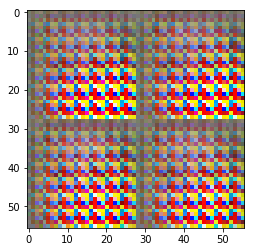

Epoch 1/1, iteration 2280: Discriminator Loss: 1.7227, Generator Loss: 0.5677


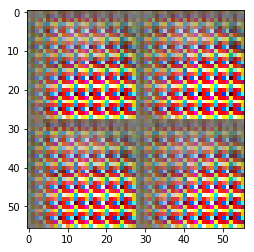

Epoch 1/1, iteration 2290: Discriminator Loss: 1.4839, Generator Loss: 0.7822


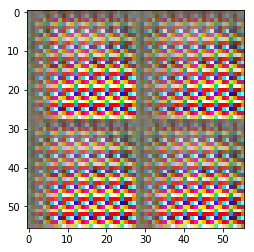

Epoch 1/1, iteration 2300: Discriminator Loss: 1.6408, Generator Loss: 0.7261


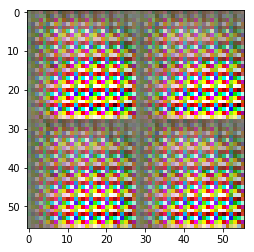

Epoch 1/1, iteration 2310: Discriminator Loss: 2.0036, Generator Loss: 0.4649


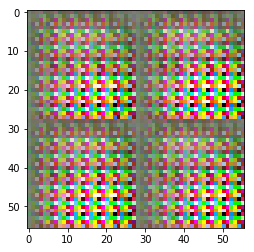

Epoch 1/1, iteration 2320: Discriminator Loss: 2.0029, Generator Loss: 0.5702


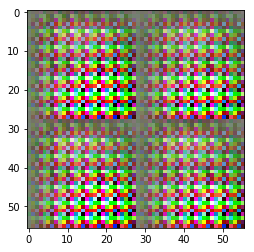

Epoch 1/1, iteration 2330: Discriminator Loss: 1.8123, Generator Loss: 0.6662


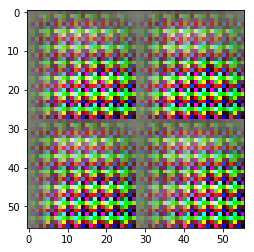

Epoch 1/1, iteration 2340: Discriminator Loss: 1.9612, Generator Loss: 0.5172


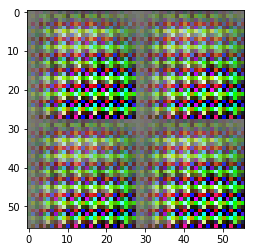

Epoch 1/1, iteration 2350: Discriminator Loss: 1.9529, Generator Loss: 0.5857


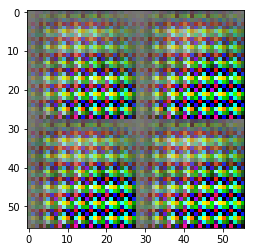

Epoch 1/1, iteration 2360: Discriminator Loss: 1.7294, Generator Loss: 0.7456


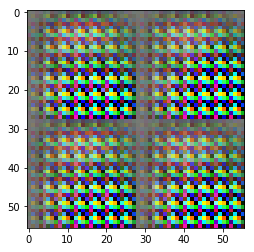

Epoch 1/1, iteration 2370: Discriminator Loss: 1.7782, Generator Loss: 0.6051


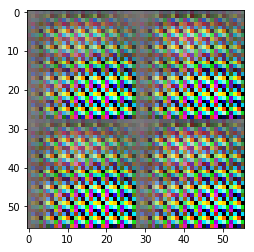

Epoch 1/1, iteration 2380: Discriminator Loss: 1.7991, Generator Loss: 0.5919


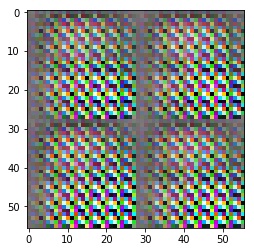

Epoch 1/1, iteration 2390: Discriminator Loss: 1.5890, Generator Loss: 0.7751


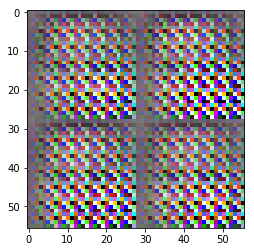

Epoch 1/1, iteration 2400: Discriminator Loss: 2.0253, Generator Loss: 0.4449


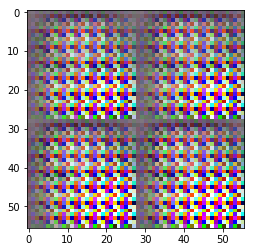

Epoch 1/1, iteration 2410: Discriminator Loss: 1.7074, Generator Loss: 0.6829


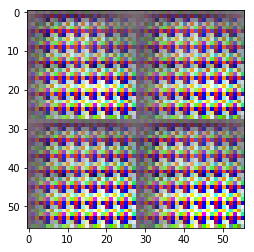

Epoch 1/1, iteration 2420: Discriminator Loss: 1.7601, Generator Loss: 0.5672


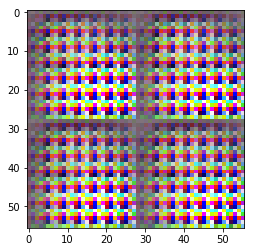

Epoch 1/1, iteration 2430: Discriminator Loss: 1.4131, Generator Loss: 0.8649


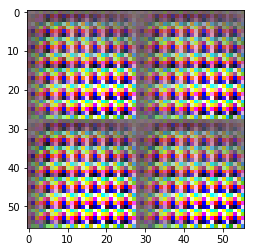

Epoch 1/1, iteration 2440: Discriminator Loss: 1.6404, Generator Loss: 0.6077


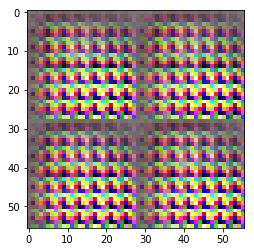

Epoch 1/1, iteration 2450: Discriminator Loss: 1.6232, Generator Loss: 0.6644


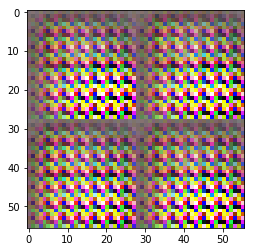

Epoch 1/1, iteration 2460: Discriminator Loss: 1.7994, Generator Loss: 0.5569


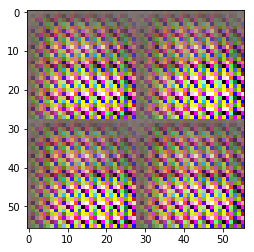

Epoch 1/1, iteration 2470: Discriminator Loss: 1.8943, Generator Loss: 0.5399


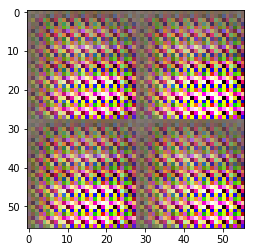

Epoch 1/1, iteration 2480: Discriminator Loss: 1.9376, Generator Loss: 0.5954


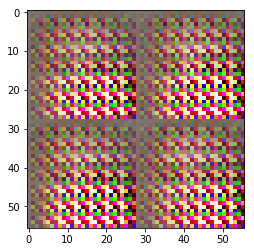

Epoch 1/1, iteration 2490: Discriminator Loss: 2.1658, Generator Loss: 0.4452


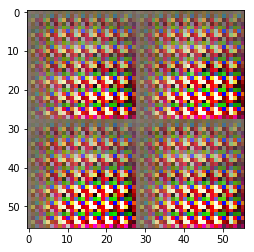

Epoch 1/1, iteration 2500: Discriminator Loss: 1.9688, Generator Loss: 0.5689


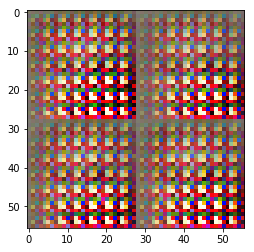

Epoch 1/1, iteration 2510: Discriminator Loss: 1.7616, Generator Loss: 0.6457


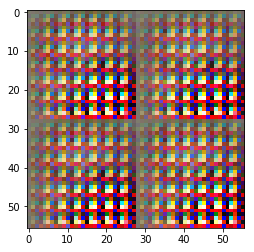

Epoch 1/1, iteration 2520: Discriminator Loss: 1.6188, Generator Loss: 0.7974


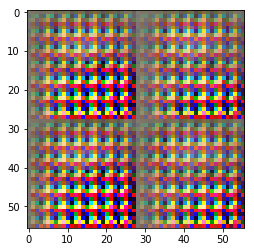

Epoch 1/1, iteration 2530: Discriminator Loss: 1.5731, Generator Loss: 0.7659


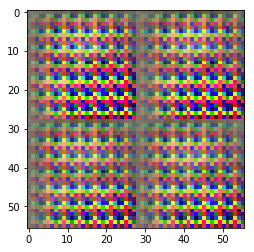

Epoch 1/1, iteration 2540: Discriminator Loss: 1.4776, Generator Loss: 0.7570


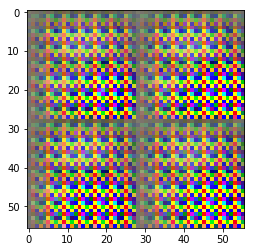

Epoch 1/1, iteration 2550: Discriminator Loss: 1.5581, Generator Loss: 0.6635


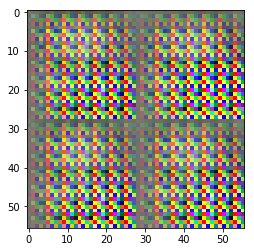

Epoch 1/1, iteration 2560: Discriminator Loss: 1.5715, Generator Loss: 0.7721


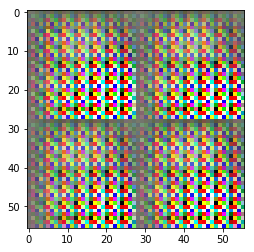

Epoch 1/1, iteration 2570: Discriminator Loss: 1.5126, Generator Loss: 0.7658


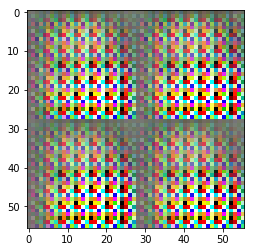

Epoch 1/1, iteration 2580: Discriminator Loss: 1.5824, Generator Loss: 0.7369


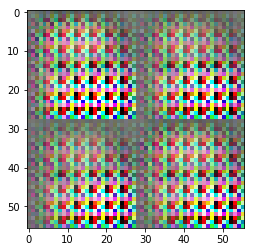

Epoch 1/1, iteration 2590: Discriminator Loss: 1.7692, Generator Loss: 0.5861


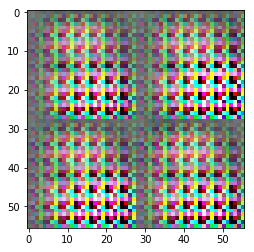

Epoch 1/1, iteration 2600: Discriminator Loss: 1.9405, Generator Loss: 0.5098


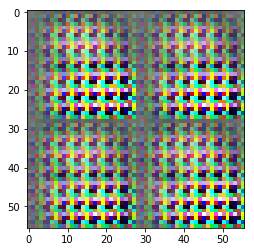

Epoch 1/1, iteration 2610: Discriminator Loss: 1.5281, Generator Loss: 0.8521


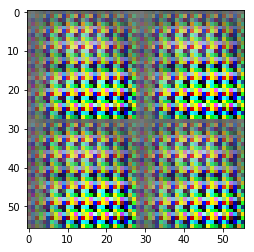

Epoch 1/1, iteration 2620: Discriminator Loss: 1.4661, Generator Loss: 0.8064


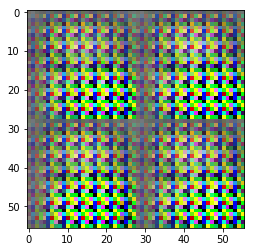

Epoch 1/1, iteration 2630: Discriminator Loss: 1.3913, Generator Loss: 0.8231


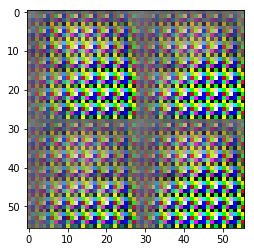

Epoch 1/1, iteration 2640: Discriminator Loss: 1.3768, Generator Loss: 0.8230


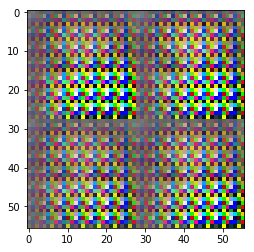

Epoch 1/1, iteration 2650: Discriminator Loss: 1.6912, Generator Loss: 0.5836


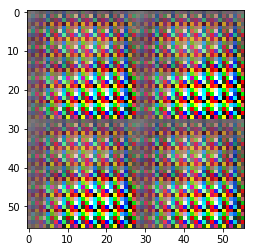

Epoch 1/1, iteration 2660: Discriminator Loss: 1.6867, Generator Loss: 0.6969


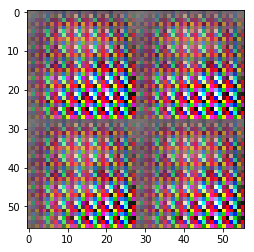

Epoch 1/1, iteration 2670: Discriminator Loss: 1.7445, Generator Loss: 0.6094


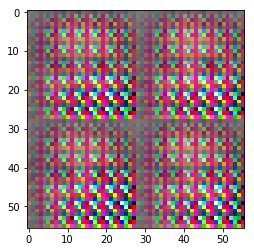

Epoch 1/1, iteration 2680: Discriminator Loss: 1.9855, Generator Loss: 0.4669


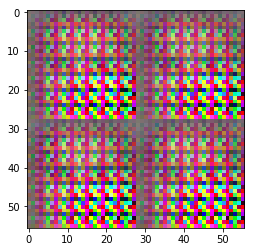

Epoch 1/1, iteration 2690: Discriminator Loss: 1.9313, Generator Loss: 0.4934


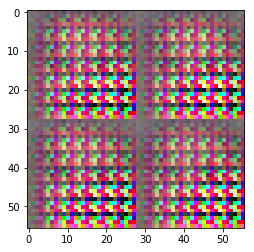

Epoch 1/1, iteration 2700: Discriminator Loss: 1.5615, Generator Loss: 0.7276


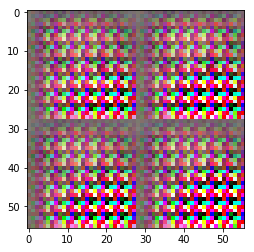

Epoch 1/1, iteration 2710: Discriminator Loss: 1.5535, Generator Loss: 0.6493


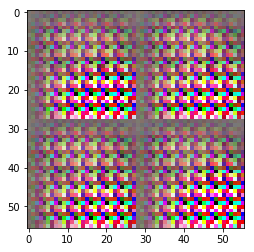

Epoch 1/1, iteration 2720: Discriminator Loss: 1.4719, Generator Loss: 0.7262


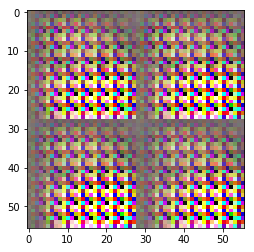

Epoch 1/1, iteration 2730: Discriminator Loss: 1.4169, Generator Loss: 0.7849


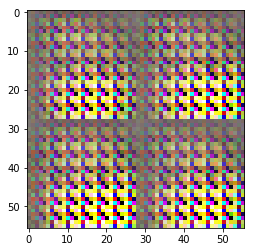

Epoch 1/1, iteration 2740: Discriminator Loss: 1.3993, Generator Loss: 0.7328


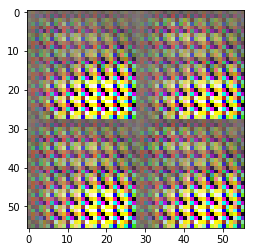

Epoch 1/1, iteration 2750: Discriminator Loss: 1.7169, Generator Loss: 0.5713


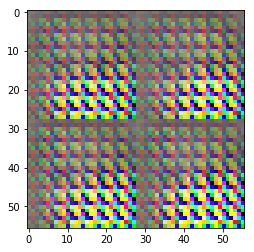

Epoch 1/1, iteration 2760: Discriminator Loss: 1.5294, Generator Loss: 0.7828


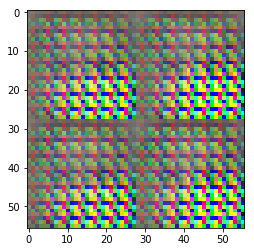

Epoch 1/1, iteration 2770: Discriminator Loss: 1.5235, Generator Loss: 0.6911


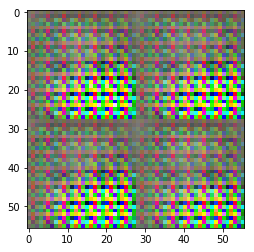

Epoch 1/1, iteration 2780: Discriminator Loss: 1.7609, Generator Loss: 0.5613


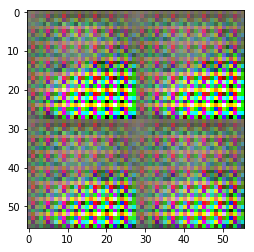

Epoch 1/1, iteration 2790: Discriminator Loss: 1.7780, Generator Loss: 0.5586


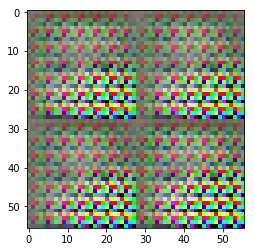

Epoch 1/1, iteration 2800: Discriminator Loss: 1.8619, Generator Loss: 0.5040


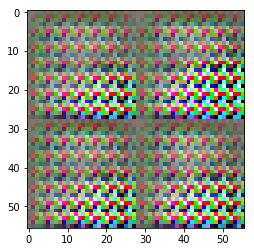

Epoch 1/1, iteration 2810: Discriminator Loss: 1.7657, Generator Loss: 0.6044


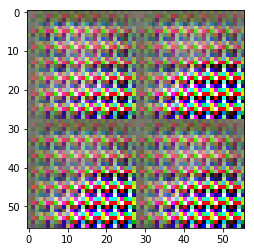

Epoch 1/1, iteration 2820: Discriminator Loss: 1.5600, Generator Loss: 0.7855


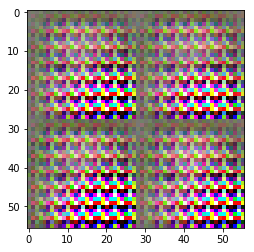

Epoch 1/1, iteration 2830: Discriminator Loss: 1.4732, Generator Loss: 0.7793


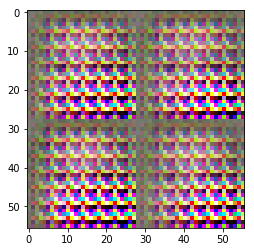

Epoch 1/1, iteration 2840: Discriminator Loss: 1.4782, Generator Loss: 0.7409


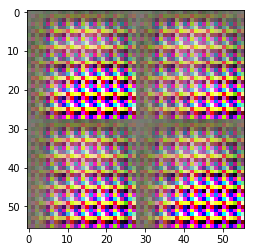

Epoch 1/1, iteration 2850: Discriminator Loss: 1.6151, Generator Loss: 0.6634


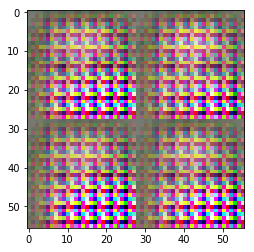

Epoch 1/1, iteration 2860: Discriminator Loss: 1.7691, Generator Loss: 0.5958


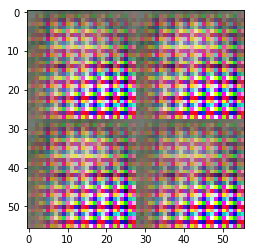

Epoch 1/1, iteration 2870: Discriminator Loss: 2.1799, Generator Loss: 0.4583


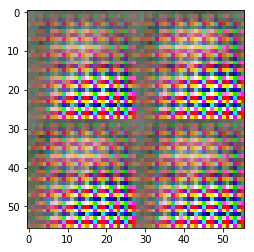

Epoch 1/1, iteration 2880: Discriminator Loss: 1.9608, Generator Loss: 0.6166


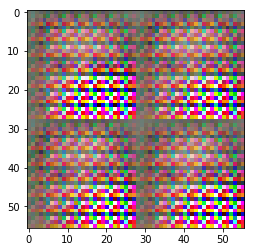

Epoch 1/1, iteration 2890: Discriminator Loss: 1.8426, Generator Loss: 0.6890


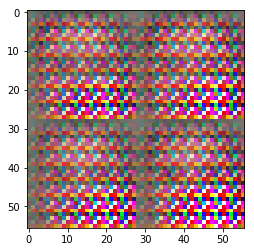

Epoch 1/1, iteration 2900: Discriminator Loss: 1.4401, Generator Loss: 1.0188


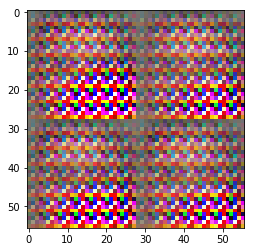

Epoch 1/1, iteration 2910: Discriminator Loss: 1.4705, Generator Loss: 0.7926


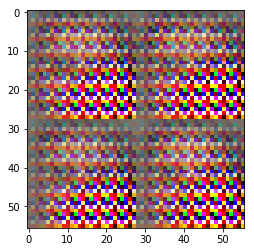

Epoch 1/1, iteration 2920: Discriminator Loss: 1.4321, Generator Loss: 0.8259


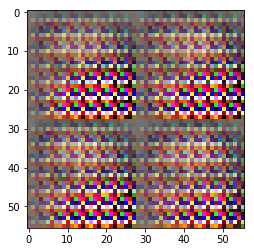

Epoch 1/1, iteration 2930: Discriminator Loss: 1.7171, Generator Loss: 0.6017


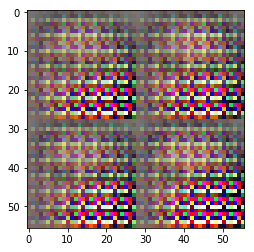

Epoch 1/1, iteration 2940: Discriminator Loss: 1.8754, Generator Loss: 0.5492


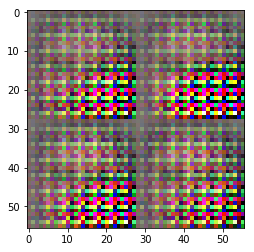

Epoch 1/1, iteration 2950: Discriminator Loss: 1.9668, Generator Loss: 0.5418


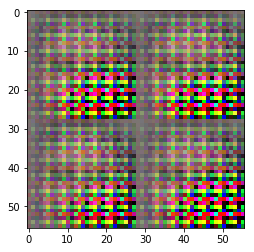

Epoch 1/1, iteration 2960: Discriminator Loss: 1.7629, Generator Loss: 0.6584


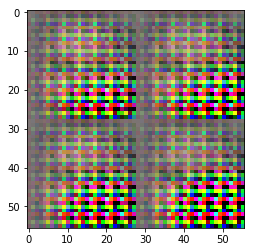

Epoch 1/1, iteration 2970: Discriminator Loss: 1.6007, Generator Loss: 0.6826


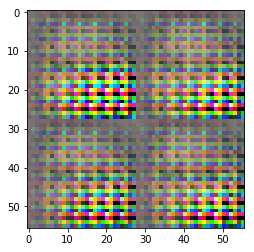

Epoch 1/1, iteration 2980: Discriminator Loss: 1.5569, Generator Loss: 0.6796


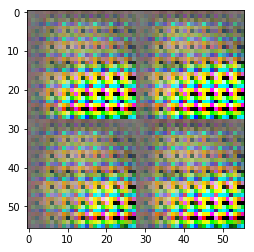

Epoch 1/1, iteration 2990: Discriminator Loss: 1.5876, Generator Loss: 0.6162


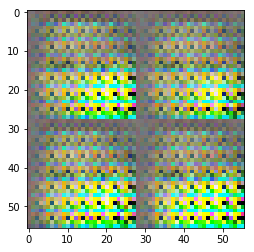

Epoch 1/1, iteration 3000: Discriminator Loss: 1.6147, Generator Loss: 0.6443


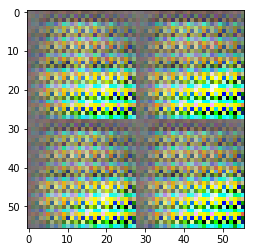

Epoch 1/1, iteration 3010: Discriminator Loss: 1.5324, Generator Loss: 0.6899


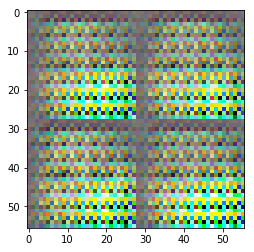

Epoch 1/1, iteration 3020: Discriminator Loss: 1.5813, Generator Loss: 0.6235


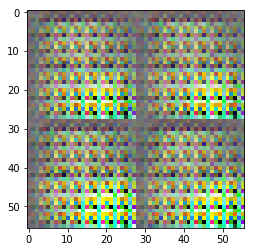

Epoch 1/1, iteration 3030: Discriminator Loss: 1.6263, Generator Loss: 0.6698


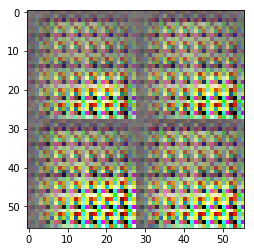

Epoch 1/1, iteration 3040: Discriminator Loss: 1.8017, Generator Loss: 0.5607


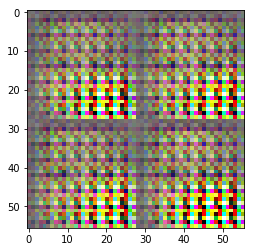

Epoch 1/1, iteration 3050: Discriminator Loss: 1.5848, Generator Loss: 0.7382


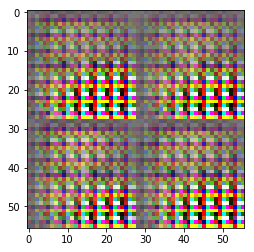

Epoch 1/1, iteration 3060: Discriminator Loss: 1.4732, Generator Loss: 0.7706


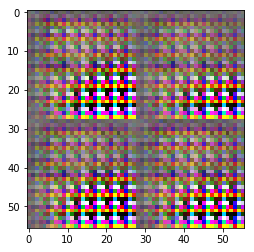

Epoch 1/1, iteration 3070: Discriminator Loss: 1.4479, Generator Loss: 0.7816


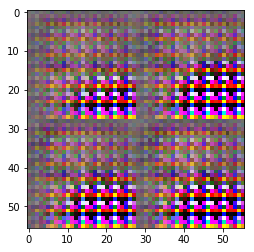

Epoch 1/1, iteration 3080: Discriminator Loss: 1.6748, Generator Loss: 0.5868


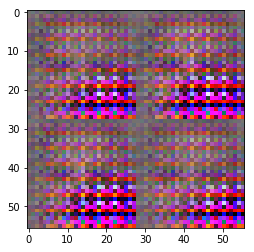

Epoch 1/1, iteration 3090: Discriminator Loss: 1.6483, Generator Loss: 0.6647


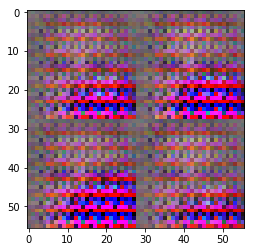

Epoch 1/1, iteration 3100: Discriminator Loss: 1.8052, Generator Loss: 0.5496


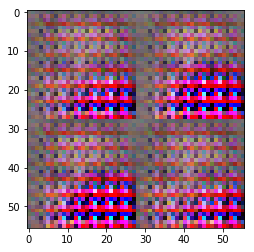

Epoch 1/1, iteration 3110: Discriminator Loss: 1.7944, Generator Loss: 0.6226


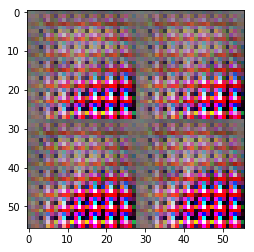

Epoch 1/1, iteration 3120: Discriminator Loss: 1.7937, Generator Loss: 0.5898


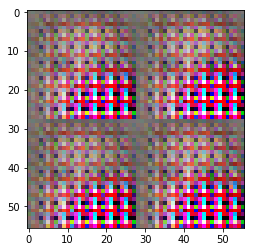

Epoch 1/1, iteration 3130: Discriminator Loss: 1.7245, Generator Loss: 0.6417


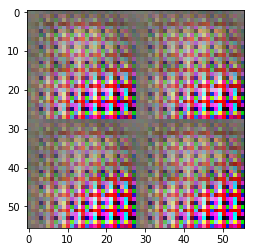

Epoch 1/1, iteration 3140: Discriminator Loss: 1.6751, Generator Loss: 0.6663


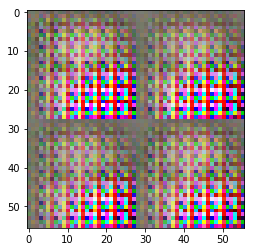

Epoch 1/1, iteration 3150: Discriminator Loss: 1.7768, Generator Loss: 0.5946


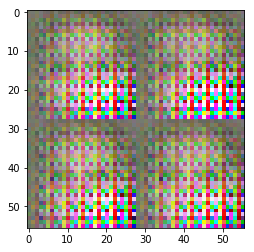

Epoch 1/1, iteration 3160: Discriminator Loss: 1.7353, Generator Loss: 0.6517


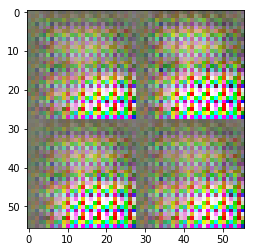

In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.